# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import regex as re
from unidecode import unidecode
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import cluster as c
from sklearn import metrics as m
from sklearn.decomposition import PCA
import sklearn.preprocessing as pp
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, KFold

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from xgboost import XGBRegressor

from boruta import BorutaPy

from scipy.stats import chi2_contingency

import umap

import pickle

from plotly import express as px
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from geopy.geocoders import Nominatim

from IPython.display import HTML, Image

import time
time_init = time.time()

## 0.1 Loading Dataset

In [2]:
prices = pd.read_csv('D:\\My Drive\\Pessoal\\Projetos\\seazone_code_challenge\\data\\raw\\Price_AV_Itapema.csv', low_memory=False)
vivareal = pd.read_csv('D:\\My Drive\\Pessoal\\Projetos\\seazone_code_challenge\\data\\raw\\VivaReal_Itapema.csv')
details = pd.read_csv('D:\\My Drive\\Pessoal\\Projetos\\seazone_code_challenge\\data\\raw\\Details_Data.csv')
hosts = pd.read_csv('D:\\My Drive\\Pessoal\\Projetos\\seazone_code_challenge\\data\\raw\\Hosts_ids_Itapema.csv')

## 0.2 Helper Functions

In [3]:
# tranform lat long in address
def get_district(x):
    geolocator = Nominatim(user_agent="geoapiExercises")
    lat = str(x[0])
    long = str(x[1])
    location = geolocator.reverse(lat+","+long, timeout=None)
    return location

# search outliers and limits
def search_outliers(df, series):
    q1 = np.percentile(df[series], 25)
    q3 = np.percentile(df[series], 75)
    distancia = q3 - q1
    salto = distancia * 1.5
    li = q1 - salto
    ls = q3 + salto
    indices = df[(df[series]<li)|(df[series]>ls)].index
    return indices, li, ls

# correlations between categorical attributes by Pearson method
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = chi2_contingency(cm)[0]
    chi2corr = max(0, chi2-(k-1)*(r-1)/(n-1))
    kcorr = k-(k-1)**2/(n-1)
    rcorr = r-(r-1)**2/(n-1)
    return round(np.sqrt((chi2corr/n)/( min(kcorr-1, rcorr-1))), 2)


def metrics(y_test, y_hat):
    # formating y values
    y_test = mm_revenue.inverse_transform(y_test.reshape(-1, 1))
    y_test = np.expm1(y_test)
    y_hat = mm_revenue.inverse_transform(y_hat.reshape(-1, 1))
    y_hat = np.expm1(y_hat)
    
    # metrics
    mean_absolute_error = np.mean(np.abs(y_test - y_hat)) # mean absolute error
    mean_absolute_percentage_error = np.mean(mean_absolute_error) / np.mean(y_test) # mean absolute percentage error
    print(f"MAE: {mean_absolute_error}")
    print(f"MAPE: {mean_absolute_percentage_error}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_hat))}")
    

def cross_validation(df, cols_selected, error, kfold, model_name, model):
    list_mean_absolute_error, list_mean_absolute_percentage_error, list_root_mean_squared_error, folds = [], [], [], []
    df = df[cols_selected].copy()
    for i in reversed(range(1, kfold+1)):
        folds.append(f'Fold: {i}')
        validation_start_date = df['date'].max() - pd.Timedelta(6*i, 'w')
        validation_end_date = df['date'].max() - pd.Timedelta(6*(i-1), 'w')
        
        train = df[df['date']<validation_start_date]
        validation = df[(df['date']>=validation_start_date)&(df['date']<=validation_end_date)]
        
        X_train = train.drop(['revenue', 'date'], axis=1)
        y_train = train['revenue']
        
        X_val = validation.drop(['revenue', 'date'], axis=1)
        y_val = validation['revenue']
        
        # fiting model
        model_fit = model.fit(X_train, y_train)

        # predicting
        y_hat = model_fit.predict(X_val)
        
        # formating y values
        y_val = mm_revenue.inverse_transform(y_val.values.reshape(-1, 1))
        y_val = np.expm1(y_val)
        y_hat = mm_revenue.inverse_transform(y_hat.reshape(-1, 1))
        y_hat = np.expm1(y_hat)
        
        list_mean_absolute_error.append(np.mean(np.abs(y_val - y_hat)))
        list_mean_absolute_percentage_error.append(np.mean(np.abs(y_val - y_hat)) / np.mean(y_val))
        list_root_mean_squared_error.append(np.sqrt(mean_squared_error(y_val, y_hat)))
        
    # mean and std
    folds.append('mean_and_std')
    list_mean_absolute_error.append(str(round(np.mean(list_mean_absolute_error), 2))+' +/- '+str(round(np.std(list_mean_absolute_error), 2)))
    list_mean_absolute_percentage_error.append(str(round(np.mean(list_mean_absolute_percentage_error), 2))+' +/- '+str(round(np.std(list_mean_absolute_percentage_error), 2)))
    list_root_mean_squared_error.append(str(round(np.mean(list_root_mean_squared_error), 2))+' +/- '+str(round(np.std(list_root_mean_squared_error), 2)))
    # dataframe
    cross_validation_metrics = pd.DataFrame([list_mean_absolute_error, list_mean_absolute_percentage_error, list_root_mean_squared_error], index=['MAE', 'MAPE', "RMSE"], columns=folds)
    error[model_name] = cross_validation_metrics['mean_and_std']
    return error, cross_validation_metrics

# 1.0 Data Description

## 1.1 Looking Datasets

In [4]:
prices.head()

,airbnb_listing_id,date,price,price_string,minimum_stay,available,aquisition_date,av_for_checkin,av_for_checkout,index,bookable,ano,mes,dia
0,22258063,2022-11-27,460.0,R$460,2,True,2022-11-27 05:28:18.654,True,NaN,NaN,NaN,2022,11,27
1,22258063,2022-11-28,460.0,R$460,2,True,2022-11-27 05:28:18.654,True,NaN,NaN,NaN,2022,11,27
2,22258063,2022-11-29,460.0,R$460,2,True,2022-11-27 05:28:18.654,True,NaN,NaN,NaN,2022,11,27
3,22258063,2022-11-30,460.0,R$460,2,True,2022-11-27 05:28:18.654,True,NaN,NaN,NaN,2022,11,27
4,22258063,2022-12-01,500.0,R$500,2,True,2022-11-27 05:28:18.654,True,NaN,NaN,NaN,2022,11,27


In [5]:
vivareal.head(3)

,listing_id,link_name,link_url,listing_type,listing_title,listing_desc,business_types,unit_type,unit_subtype,property_type,...,advertiser_id,advertiser_name,advertiser_phones,advertiser_whatsapp,advertiser_url,portal,aquisition_date,ano,mes,dia
0,2570403797,"Apartamento com 4 Quartos à venda, 187m²",https://www.vivareal.com.br/imovel/apartamento...,USED,"Apartamento com 4 dormitórios à venda, 187 m² ...",Situado em uma das melhores regiões da Meia Pr...,"[""SALE""]",APARTMENT,NaN,UNIT,...,39507409-01f8-3935-dc38-e0fea684b44a,Winner Brokers,"[""44984349088""]",4.498435e+10,https://www.vivareal.com.br/770696/winner-brok...,GRUPOZAP,2022-12-06 00:00:00.000,2022,12,6
1,2510420914,"Apartamento com 4 Quartos à venda, 253m²",https://www.vivareal.com.br/imovel/apartamento...,USED,Apartamento com 4 suítes 3 vagas em Itapema SC,"Apartamentos com 04 suítes, 03 vagas de garage...","[""SALE""]",APARTMENT,NaN,UNIT,...,cc5bc87d-b746-8b05-90f8-ef61f5020a69,FRANCA FERRAZ IMOBILIARIA,"[""4733630740"", ""47996961130""]",4.799696e+10,https://www.vivareal.com.br/116267/franca-ferr...,GRUPOZAP,2022-12-06 00:00:00.000,2022,12,6
2,2594648655,"Apartamento com 4 Quartos à venda, 210m²",https://www.vivareal.com.br/imovel/apartamento...,USED,"Apartamento à venda, Centro, Itapema, SC","Apartamento à Venda, 210m² por R$ 3.000.000. C...","[""SALE""]",APARTMENT,NaN,UNIT,...,ac9f84ae-1363-d2aa-1a6d-4adf1631539f,ARBO IMÓVEIS,"[""11999293012""]",1.199929e+10,https://www.vivareal.com.br/656548/arbo-imoveis/,GRUPOZAP,2022-12-06 00:00:00.000,2022,12,6


In [6]:
details.head(3)

,aquisition_date,url,ad_name,ad_description,ad_id,space,house_rules,amenities,safety_features,number_of_bathrooms,...,index,localized_star_rating,response_time_shown,response_rate_shown,guest_satisfaction_overall,picture_count,min_nights,ano,mes,dia
0,2022-07-11 07:21:51.61831,https://www.airbnb.com.br/rooms/27865733,Carambei 106,"Apartamento para 8 pessoas, lateral p praia. P...",27865733,Espaco TOP tipo hotel,"{""Não são permitidas festas ou eventos"",""Anima...","{Cabides,""Ferro de passar"",""Máquina de Lavar"",...",{},2.0,...,11043701.0,NaN,em até uma hora,100%,100.0,31.0,2.0,2022,7,11
1,2022-07-11 07:28:25.226756,https://www.airbnb.com.br/rooms/52200210,Apto aconchegante na rua + procurada da Meia P...,Sua família vai estar perto de tudo ao ficar n...,52200210,NaN,"{""Animais de estimação são permitidos""}","{""Máquina de Lavar"",TV,Ar-condicionado,Wi-Fi,""...",{},2.0,...,11082903.0,"5,0",em até uma hora,100%,100.0,43.0,2.0,2022,7,11
2,2022-07-18 07:19:40.053547,https://www.airbnb.com.br/rooms/53372578,Ótimo apartamento em Itapema,Ótimo para período de férias,53372578,"O Ap é bastante amplo, sala de star e jantar i...","{""Animais de estimação são permitidos""}","{""Local para guardar as roupas"",""Blackout nas ...","{""Extintor de incêndio""}",2.0,...,11300813.0,"3,0",NaN,NaN,60.0,11.0,7.0,2022,7,18


In [7]:
hosts.head(3)

,host_id,host_name,host_rating,n_reviews,n_reviews_from_host,n_listings,about_host,comments,aquisition_date,ano,mes,dia
0,160913639,Cayo,0.000,0,0,1,NaN,NaN,2022-12-05,2022,12,5
1,84162292,Ricardo,4.935,42,1,3,"Sou casado, tenho uma filha de 9 anos e um fil...","[""Obrigado Ricardo a estadia foi ótima muito ...",2022-12-05,2022,12,5
2,96045548,Eduardo,0.000,26,0,3,NaN,"[""Otimo"", ""muito bom local e muito claro nas e...",2022-12-05,2022,12,5


## 1.2 Data Dimensions

In [8]:
print('prices')
print(f'Rows qtd: {prices.shape[0]}')
print(f'Columns qtd: {prices.shape[1]}\n')
print('vivareal')
print(f'Rows qtd: {vivareal.shape[0]}')
print(f'Columns qtd: {vivareal.shape[1]}\n')
print('details')
print(f'Rows qtd: {details.shape[0]}')
print(f'Columns qtd: {details.shape[1]}\n')
print('hosts')
print(f'Rows qtd: {hosts.shape[0]}')
print(f'Columns qtd: {hosts.shape[1]}\n')

prices
Rows qtd: 43020080
Columns qtd: 14

vivareal
Rows qtd: 17547
Columns qtd: 42

details
Rows qtd: 32558
Columns qtd: 37

hosts
Rows qtd: 1357
Columns qtd: 12



## 1.3 Datatypes

In [9]:
prices.dtypes

airbnb_listing_id      int64
date                  object
price                float64
price_string          object
minimum_stay           int64
available               bool
aquisition_date       object
av_for_checkin        object
av_for_checkout      float64
index                float64
bookable             float64
ano                    int64
mes                    int64
dia                    int64
dtype: object

In [10]:
hosts.dtypes

host_id                  int64
host_name               object
host_rating            float64
n_reviews                int64
n_reviews_from_host      int64
n_listings               int64
about_host              object
comments                object
aquisition_date         object
ano                      int64
mes                      int64
dia                      int64
dtype: object

In [11]:
details.dtypes

aquisition_date                object
url                            object
ad_name                        object
ad_description                 object
ad_id                           int64
space                          object
house_rules                    object
amenities                      object
safety_features                object
number_of_bathrooms           float64
number_of_bedrooms            float64
number_of_beds                float64
latitude                      float64
longitude                     float64
star_rating                   float64
additional_house_rules         object
owner                          object
check_in                       object
check_out                      object
number_of_guests                int64
is_superhost                     bool
number_of_reviews               int64
cohosts                        object
cleaning_fee                  float64
can_instant_book                 bool
owner_id                        int64
listing_type

In [12]:
vivareal.dtypes

listing_id                 int64
link_name                 object
link_url                  object
listing_type              object
listing_title             object
listing_desc              object
business_types            object
unit_type                 object
unit_subtype              object
property_type             object
usage_type                object
sale_price               float64
rental_price             float64
rental_period             object
yearly_iptu              float64
monthly_condo_fee        float64
amenities                 object
usable_area              float64
total_area               float64
bathrooms                float64
bedrooms                 float64
suites                   float64
parking_spaces           float64
address_country           object
address_state             object
address_city              object
address_neighborhood      object
address_street            object
address_street_number     object
address_complement       float64
address_zi

## 1.4 Check Na

In [13]:
round(prices.isna().sum() / prices['airbnb_listing_id'].count() * 100, 2)

airbnb_listing_id      0.00
date                   0.00
price                  0.01
price_string           0.00
minimum_stay           0.00
available              0.00
aquisition_date        0.00
av_for_checkin         0.09
av_for_checkout      100.00
index                100.00
bookable             100.00
ano                    0.00
mes                    0.00
dia                    0.00
dtype: float64

In [14]:
round(hosts.isna().sum() / hosts['host_id'].count() * 100, 2)

host_id                 0.00
host_name               0.00
host_rating             0.00
n_reviews               0.00
n_reviews_from_host     0.00
n_listings              0.00
about_host             76.05
comments               21.81
aquisition_date         0.00
ano                     0.00
mes                     0.00
dia                     0.00
dtype: float64

In [15]:
round(details.isna().sum() / details['aquisition_date'].count() * 100, 2)

aquisition_date                0.00
url                            0.00
ad_name                        0.00
ad_description                 5.75
ad_id                          0.00
space                         47.46
house_rules                    9.48
amenities                      0.00
safety_features                0.00
number_of_bathrooms            0.23
number_of_bedrooms             1.59
number_of_beds                 0.57
latitude                       0.00
longitude                      0.00
star_rating                   47.69
additional_house_rules        57.24
owner                          0.00
check_in                       8.31
check_out                     20.60
number_of_guests               0.00
is_superhost                   0.00
number_of_reviews              0.00
cohosts                       87.16
cleaning_fee                   0.00
can_instant_book               0.00
owner_id                       0.00
listing_type                   0.00
index                       

In [16]:
round(vivareal.isna().sum() / vivareal['listing_id'].count() * 100, 2)

listing_id                 0.00
link_name                  0.00
link_url                   0.00
listing_type               0.00
listing_title              0.06
listing_desc               0.54
business_types             0.00
unit_type                  0.00
unit_subtype              98.66
property_type              0.00
usage_type                 0.00
sale_price                 6.42
rental_price              93.35
rental_period             93.35
yearly_iptu               56.64
monthly_condo_fee         56.39
amenities                  0.00
usable_area                0.03
total_area                11.81
bathrooms                  0.23
bedrooms                   0.51
suites                     7.06
parking_spaces             4.47
address_country            0.00
address_state              0.00
address_city               0.00
address_neighborhood       5.37
address_street            38.38
address_street_number     41.03
address_complement       100.00
address_zipcode            0.10
location

## 1.5 Fillout Na

In [17]:
map_bedrooms_by_guests = details.groupby('number_of_guests').agg({'number_of_bedrooms':'mean'})['number_of_bedrooms'].round()
temp = details.loc[details['number_of_bedrooms'].isna(), 'number_of_guests'].map(map_bedrooms_by_guests).values
details.loc[details['number_of_bedrooms'].isna(), 'number_of_bedrooms'] = temp

map_bathrooms_by_guests = details.groupby('number_of_guests').agg({'number_of_bathrooms':'mean'})['number_of_bathrooms'].round()
temp = details.loc[details['number_of_bathrooms'].isna(), 'number_of_guests'].map(map_bathrooms_by_guests).values
details.loc[details['number_of_bathrooms'].isna(), 'number_of_bathrooms'] = temp

map_beds_by_guests = details.groupby('number_of_guests').agg({'number_of_beds':'mean'})['number_of_beds'].round()
temp = details.loc[details['number_of_beds'].isna(), 'number_of_guests'].map(map_beds_by_guests).values
details.loc[details['number_of_beds'].isna(), 'number_of_beds'] = temp

## 1.6 Rename Columns

In [18]:
prices.rename(columns={'airbnb_listing_id':'airbnb_id'}, inplace=True)
details.rename(columns={'ad_id':'airbnb_id'}, inplace=True)

## 1.7 Data Cleaning I

### 1.7.1 prices

#### 1.7.1 duplicates

In [19]:
prices = prices[~prices[['airbnb_id', 'date']].duplicated()]

#### 1.7.2 available

In [20]:
prices['available'] = prices['available'].apply(lambda x: 1 if x==True else 0)

### 1.7.2 details

#### 1.7.2.1 safety_features

In [21]:
details['safety_features'] = details['safety_features'].apply(lambda x: re.sub('[^a-zA-Z0-9\n.çêó]', ' ', x))
details['safety_features'] = details['safety_features'].str.replace(' ', '')
details['safety_features'] = details['safety_features'].str.replace('Trancanaportadoquarto','')
details['safety_features'] = details['safety_features'].str.replace('u00ea', 'ê')
details['safety_features'] = details['safety_features'].str.replace('u00e7', 'ç')
details['safety_features'] = details['safety_features'].str.replace('u00f3', 'ó')

#### 1.7.2.2 amenities

In [22]:
details['amenities'] = details['amenities'].apply(lambda x: re.sub('[^a-zA-ZÁáíêç]', '', x))
details['amenities'] = details['amenities'].apply(lambda x: x.replace('Extintordeincêndio', ''))
details['amenities'] = details['amenities'].apply(lambda x: x.replace('Detectordefumaça', ''))
details['amenities'] = details['amenities'].apply(lambda x: x.replace('Kitdeprimeirossocorros', ''))
details['amenities'] = details['amenities'].apply(lambda x: x.replace('Trancanaportadoquarto', ''))
details['amenities'] = details['amenities'].apply(lambda x: x.replace('Águaquente', ''))
details['amenities'] = details['amenities'].apply(lambda x: x.replace('Cabides', ''))

#### 1.7.2.3 is_superhost

In [23]:
details['is_superhost'] = details['is_superhost'].apply(lambda x: 1 if x == True else 0)

## 1.8 Changing Datatypes

In [24]:
# prices
prices['available'] = prices['available'].astype(int)
prices['date'] = pd.to_datetime(prices['date'])

# details
details['number_of_bathrooms'] = details['number_of_bathrooms'].astype(int)
details['number_of_bedrooms'] = details['number_of_bedrooms'].astype(int)
details['number_of_beds'] = details['number_of_beds'].astype(int)

## 1.9 Integrating Dataframes

### 1.9.1 Merging

In [25]:
df = prices[['airbnb_id', 'date', 'price', 'available']]

temp = details[['airbnb_id', 'cleaning_fee', 'number_of_bathrooms', 'number_of_bedrooms', 'number_of_beds', 'number_of_guests', 'safety_features', 'amenities', 'latitude', 'longitude', 'listing_type', 'ad_description', 'ad_name', 'space', 'is_superhost', 'min_nights']]
temp = temp.groupby('airbnb_id').agg({'cleaning_fee':'median', 'number_of_bathrooms':'median', 'number_of_bedrooms':'median', 'number_of_beds':'median', 'number_of_guests':'median', 'safety_features':'first', 'amenities':'first', 'latitude':'first', 'longitude':'first', 'listing_type':'first', 'ad_description':'first', 'ad_name':'first', 'space':'first', 'is_superhost':'first', 'min_nights':'mean'})

df = pd.merge(df, temp, on='airbnb_id', how='left')

### 1.9.2 Data Dimension

In [26]:
print(f'Quantity of rows: {df.shape[0]}')
print(f'Quantity of columns: {df.shape[1]}')

Quantity of rows: 968832
Quantity of columns: 19


### 1.9.3 Check Na

In [27]:
df.isna().sum() / df['airbnb_id'].count()

airbnb_id              0.000000
date                   0.000000
price                  0.000029
available              0.000000
cleaning_fee           0.000000
number_of_bathrooms    0.000000
number_of_bedrooms     0.000000
number_of_beds         0.000000
number_of_guests       0.000000
safety_features        0.000000
amenities              0.000000
latitude               0.000000
longitude              0.000000
listing_type           0.000000
ad_description         0.049710
ad_name                0.000000
space                  0.507706
is_superhost           0.000000
min_nights             0.331674
dtype: float64

## 1.10 Descriptive Statistical

In [28]:
num_attributes = ['price', 'cleaning_fee']

### 1.10.1 Numerical Attributes

In [29]:
# Central tendency
ct1 = pd.DataFrame(df[num_attributes].apply(np.mean)).T
ct2 = pd.DataFrame(df[num_attributes].apply(np.median)).T

# Dispersion
d1 = pd.DataFrame(df[num_attributes].apply(np.std)).T
d2 = pd.DataFrame(df[num_attributes].apply(min)).T
d3 = pd.DataFrame(df[num_attributes].apply(max)).T
d4 = pd.DataFrame(df[num_attributes].apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(df[num_attributes].apply(lambda x: x.skew())).T
d6 = pd.DataFrame(df[num_attributes].apply(lambda x: x.kurtosis())).T

# Concat
temp = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T
temp.columns = 'min max range mean median std skew kurtosis'.split()
temp

,min,max,range,mean,median,std,skew,kurtosis
price,48.0,500900.0,500852.0,953.390411,NaN,7906.074159,41.759276,2063.143521
cleaning_fee,0.0,1200.0,1200.0,191.087396,200.0,111.185483,0.543377,4.043620


* price com média e mediana completamente deslocadas, skew alta, kurtosis enorme, indícios de outliers muito elevados.
* cleaning fee com valores zerados, com distribuição aparentemente normal.

In [30]:
df[num_attributes].describe()

,price,cleaning_fee
count,968804.000000,968832.000000
mean,953.390411,191.087396
std,7906.078239,111.185541
min,48.000000,0.000000
25%,310.000000,150.000000
50%,500.000000,200.000000
75%,800.000000,250.000000
max,500900.000000,1200.000000


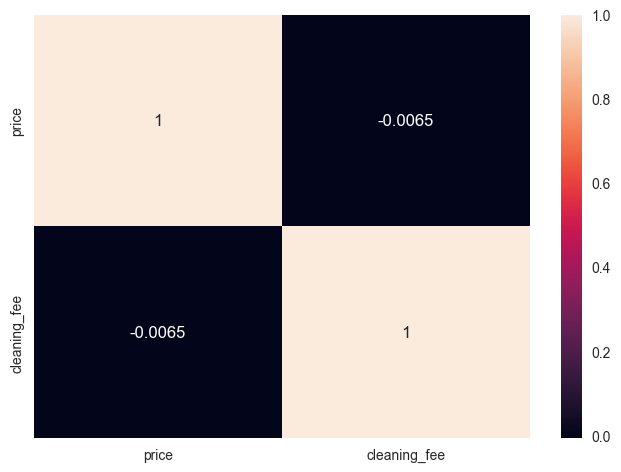

In [31]:
sns.heatmap(df[num_attributes].corr(), annot=True);

* Correlação inexistente entre cleaning_fee e price

### 1.10.2 Categorical Attributes

In [32]:
cat_attributes = ['available', 'number_of_bathrooms', 'number_of_bedrooms', 'number_of_beds', 'number_of_guests']

In [33]:
df[cat_attributes].apply(lambda x: x.nunique())

available               2
number_of_bathrooms     9
number_of_bedrooms     10
number_of_beds         23
number_of_guests       18
dtype: int64

In [34]:
temp = df[cat_attributes].copy()

for i in cat_attributes:
    temp[i] = temp[i].astype(str)

In [35]:
temp.describe().T

,count,unique,top,freq
available,968832,2,1,611823
number_of_bathrooms,968832,9,2.0,495298
number_of_bedrooms,968832,10,3.0,431425
number_of_beds,968832,23,3.0,294739
number_of_guests,968832,18,6.0,265772


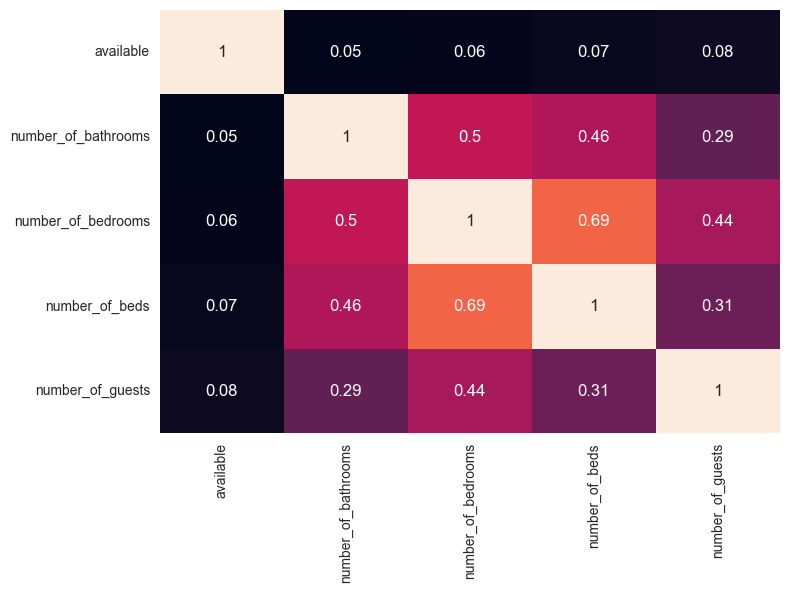

In [36]:
cramer_correlation = []

for i, col_1 in enumerate(cat_attributes):
    for j, col_2 in enumerate(cat_attributes):
        cramer_correlation.append(cramer_v(df[col_1], df[col_2]))
        
matrix = pd.DataFrame(np.array(cramer_correlation).reshape(5, 5), index=cat_attributes, columns=cat_attributes)

sns.heatmap(matrix, annot=True, cbar=False);

* guests, bedrooms, bathrooms and bads high correlated

Very high priced airbnb's are in almost every way bigger or better than regular priced airbnb's

# 2.0 Data Filtering

## 2.1 Columns Filtering

## 2.2 Rows Filtering

### 2.2.1 df

In [37]:
ix, li, ls = search_outliers(df, 'price')

In [38]:
df.loc[ix, 'price'] = df.loc[ix, 'price'].clip(upper=4000)

In [39]:
df.dropna(inplace=True)

### 2.2.1 vivareal

In [40]:
ix = vivareal.loc[vivareal['business_types']=='["RENTAL"]'].index

vivareal.drop(ix, inplace=True)

# ix, li, ls = search_outliers(vivareal[vivareal['sale_price'].notna()], 'sale_price')

# vivareal.drop(ix, inplace=True)

In [41]:
vivareal = vivareal[vivareal['listing_type']=='USED']

# 3.0 Feature Engineering

## 3.1 details

### 3.1.1 safety_features dummies

In [42]:
temp = 'Extintordeincêndio Detectordefumaça Alarmedemonóxidodecarbono Kitdeprimeirossocorros'.split()
df['extintordeincendio'] = df['safety_features'].apply(lambda x: 1 if temp[0] in x else 0)
df['detectordefumaça'] = df['safety_features'].apply(lambda x: 1 if temp[1] in x else 0)
df['alarmedemonoxidodecarbono'] = df['safety_features'].apply(lambda x: 1 if temp[2] in x else 0)
df['kitdeprimeirossocorros'] = df['safety_features'].apply(lambda x: 1 if temp[3] in x else 0)
df.drop('safety_features', axis=1, inplace=True)

### 3.1.2 amenities dummies

In [43]:
temp = 'MáquinadeLavar TV Arcondicionado WiFi Cozinha Churrasqueira Estacionamentoincluído Chuveiroexterno Elevador Ferrodepassar'.split()

df['MáquinadeLavar'] = df['amenities'].apply(lambda x: 1 if temp[0] in x else 0)
df['TV'] = df['amenities'].apply(lambda x: 1 if temp[1] in x else 0)
df['Arcondicionado'] = df['amenities'].apply(lambda x: 1 if temp[2] in x else 0)
df['WiFi'] = df['amenities'].apply(lambda x: 1 if temp[3] in x else 0)
df['Cozinha'] = df['amenities'].apply(lambda x: 1 if temp[4] in x else 0)
df['Churrasqueira'] = df['amenities'].apply(lambda x: 1 if temp[5] in x else 0)
df['Estacionamentoincluído'] = df['amenities'].apply(lambda x: 1 if temp[6] in x else 0)
df['Chuveiroexterno'] = df['amenities'].apply(lambda x: 1 if temp[7] in x else 0)
df['Elevador'] = df['amenities'].apply(lambda x: 1 if temp[8] in x else 0)
df['Ferrodepassar'] = df['amenities'].apply(lambda x: 1 if temp[9] in x else 0)
df.drop('amenities', axis=1, inplace=True)

### 3.1.3 neighborhood

In [44]:
ref = df.groupby('airbnb_id').agg({'latitude':'first', 'longitude':'first'}).reset_index()
# temp = ref.iloc[0:500][['latitude', 'longitude']].apply(lambda x: get_district(x), axis=1)
# temp1 = ref.iloc[500:1000][['latitude', 'longitude']].apply(lambda x: get_district(x), axis=1)
# temp2 = ref.iloc[1000:1500][['latitude', 'longitude']].apply(lambda x: get_district(x), axis=1)
# temp3 = ref.iloc[1500:][['latitude', 'longitude']].apply(lambda x: get_district(x), axis=1)
# address = [temp, temp1, temp2, temp3]
# pickle.dump(address, open('D:\\My Drive\\Pessoal\\Projetos\\seazone_code_challenge\\data\\interim\\address.pkl', 'wb'))
# time.sleep(30)
address = pickle.load(open('D:\\My Drive\\Pessoal\\Projetos\\seazone_code_challenge\\data\\interim\\address.pkl', 'rb'))
ref['address'] = address[0].append(address[1]).append(address[2]).append(address[3])
ref['neighborhood'] = ref['address'].apply(lambda x: x[0].split(',')[1])
neighborhood_list = ref['neighborhood'].value_counts().keys().to_list()
neighborhood = []

for i in neighborhood_list:
    i = i.replace(' ', '')
    if i.isalpha():
        neighborhood.append(i)

neighborhood.extend(['VilaNova', 'RioPequeno'])
temp = 'Areal RegiãoGeográficaImediatadeItajaí RuaGuilhermeMarian RuaJoséAlexandreRocha RuaBeijaFlor RodoviaGovernadorMárioCovas RuaIgrejaEvangélicaAssembleiadeDeus AvenidaGovernadorCelsoRamos AvenidaNereuRamos LoteamentoItapema'.split()

for i in temp:
    try:
        bairros.remove(i)
    except:
        pass

def neighborhood_clean(x):
    x = x[0].replace(' ', '')
    for i in neighborhood:
        if i in x:
            return i

ref['neighborhood'] = ref['address'].apply(lambda x: neighborhood_clean(x))
df = pd.merge(df, ref[['airbnb_id', 'neighborhood']], on='airbnb_id', how='left')
df.drop(['latitude', 'longitude'], axis=1, inplace=True)

C:\Users\Samoel\AppData\Local\Temp\ipykernel_9768\3960031341.py:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ref['address'] = address[0].append(address[1]).append(address[2]).append(address[3])


### 3.1.4 unit_type

In [45]:
apartment = df['listing_type'].dropna().apply(lambda x: 'apartamento' in x.lower() or 'apto' in x.lower() or 'ap' in x.lower() or 'cobertura' in x.lower() or 'duplex' in x.lower() or 'triplex' in x.lower())
apartment = list(df['listing_type'].dropna().loc[apartment].index)
home = df['listing_type'].dropna().apply(lambda x: 'casa' in x.lower() or 'sobrado' in x.lower())
home = list(df['listing_type'].dropna().loc[home].index)
both = list(set(apartment)&set(home))
home = list(set(home) - set(both))
df.loc[home, 'unit_type'] = 'HOME'
df.loc[apartment, 'unit_type'] = 'APARTMENT'

apartment = df['ad_description'].dropna().apply(lambda x: 'apartamento' in x.lower() or 'apto' in x.lower() or 'ap' in x.lower() or 'cobertura' in x.lower() or 'duplex' in x.lower() or 'triplex' in x.lower())
apartment = list(df['ad_description'].dropna().loc[apartment].index)
home = df['ad_description'].dropna().apply(lambda x: 'casa' in x.lower() or 'sobrado' in x.lower())
home = list(df['ad_description'].dropna().loc[home].index)
both = list(set(apartment)&set(home))
home = list(set(home) - set(both))
df.loc[home, 'unit_type'] = 'HOME'
df.loc[apartment, 'unit_type'] = 'APARTMENT'

apartment = df['ad_name'].dropna().apply(lambda x: 'apartamento' in x.lower() or 'apto' in x.lower() or 'ap' in x.lower() or 'cobertura' in x.lower() or 'duplex' in x.lower() or 'triplex' in x.lower())
apartment = list(df['ad_name'].dropna().loc[apartment].index)
home = df['ad_name'].dropna().apply(lambda x: 'casa' in x.lower() or 'sobrado' in x.lower())
home = list(df['ad_name'].dropna().loc[home].index)
both = list(set(apartment)&set(home))
home = list(set(home) - set(both))
df.loc[home, 'unit_type'] = 'HOME'
df.loc[apartment, 'unit_type'] = 'APARTMENT'

apartment = df['space'].dropna().apply(lambda x: 'apartamento' in x.lower() or 'apto' in x.lower() or 'ap' in x.lower() or 'cobertura' in x.lower() or 'duplex' in x.lower() or 'triplex' in x.lower())
apartment = list(df['space'].dropna().loc[apartment].index)
home = df['space'].dropna().apply(lambda x: 'casa' in x.lower() or 'sobrado' in x.lower())
home = list(df['space'].dropna().loc[home].index)
both = list(set(apartment)&set(home))
home = list(set(home) - set(both))
df.loc[home, 'unit_type'] = 'HOME'
df.loc[apartment, 'unit_type'] = 'APARTMENT'
df.drop(['listing_type', 'ad_description', 'ad_name', 'space'], axis=1, inplace=True)

## 3.2 vivareal

### 3.2.1 neighborhood

In [46]:
vivareal['neighborhood'] = vivareal['location_id'].apply(lambda x: x.split('>')[-1])
vivareal.loc[(vivareal['neighborhood']=='Itapema', 'neighborhood')] = vivareal.loc[(vivareal['neighborhood']=='Itapema', 'address_neighborhood')]
vivareal.loc[vivareal['neighborhood'].isin(['Itapema', 'itapema']), 'neighborhood'] = np.nan

### 3.2.2 bedrooms and area

In [47]:
vivareal['bedrooms'] = vivareal['link_name'].apply(lambda x: re.sub('[^0-9,]', '', x)).apply(lambda x: x.split(',')[0])
vivareal['area'] = vivareal['link_name'].apply(lambda x: re.sub('[^0-9,]', '', x)).apply(lambda x: x.split(',')[-1])

def vivareal_area_or_bedrooms(x):
    bedrooms = x[0]
    if len(bedrooms) >= 3:
        area = bedrooms[1:]
        bedrooms = bedrooms[0]
    else:
        area = x[1]
    return bedrooms, area
        
temp = vivareal[['bedrooms', 'area']].apply(vivareal_area_or_bedrooms, axis=1)
vivareal['bedrooms'] = temp.str[0]
vivareal['area'] = temp.str[1]

# Fillout empty values and outliers
vivareal = vivareal[vivareal['area']!='']
vivareal = vivareal[vivareal['bedrooms']!='']

# Changing Datatypes
vivareal['area'] = vivareal['area'].astype(int)
vivareal['bedrooms'] = vivareal['bedrooms'].astype(int)

# Fillout outliers
ix = vivareal[vivareal['area']>1000].index
vivareal.drop(ix, axis=0, inplace=True)

ix = vivareal.loc[vivareal['bedrooms']>=8].index
vivareal.drop(ix, inplace=True)

## 3.3 df

In [48]:
# revenue
df.loc[df['available']==0, 'revenue'] = df.loc[df['available']==0, 'price']
df.loc[df['revenue'].isna(), 'revenue'] = 0
df['revenue'] = df['revenue'].astype(int)

# area
area_bedroom_mean = vivareal.groupby('bedrooms').agg({'area':'median'})['area']
df['area'] = df['number_of_bedrooms'].map(area_bedroom_mean)

# year
df['year'] = df['date'].dt.year

# month
df['month'] = df['date'].dt.month

# week of year
df['week_of_year'] = df['date'].dt.isocalendar().week

# day
df['day'] = df['date'].dt.day

In [49]:
df.loc[df['unit_type'].isna(), 'unit_type'] = 'other'
df.loc[df['area'].isna(), 'area'] = df['area'].median()

### 3.3.1 Data Cleaning II

### 3.3.1.1 price

###### Replacement by First 3 Digits

In [50]:
rev_before = df['revenue'].sum()

ix, li, ls = search_outliers(df, 'price')
before = len(ix)

df.loc[df['price']>=10300, 'temp'] = df.loc[df['price']>=10300, 'price'].apply(lambda x: str(x)[:3])

df['temp'] = df['temp'].astype(float)

df.loc[df['temp'].notna(), 'price'] = df.loc[df['temp'].notna(), 'temp']

df.drop('temp', axis=1, inplace=True)

df['revenue'] = df[['available', 'price']].apply(lambda x: x[1] if x[0] == 0 else 0, axis=1)

ix, li, ls = search_outliers(df, 'price')
print(f"Replaced {round((before - len(ix)) / before * 100, 2)}% of outliers price's len")

print(f"{round((rev_before - df['revenue'].sum()) / rev_before * 100, 2)}% of revenue")

Replaced 0.56% of outliers price's len
29.33% of revenue


###### Airbnb_id's Individually With Price With Input Error: All Samples with Error

Possibly the owner leaves the status of the property as unavailable for different reasons, not always generating revenue

In [51]:
temp = '21045150 41409542 21924943 29013812 16428654 31649240'.split()

In [52]:
df = df.loc[~df['airbnb_id'].astype(str).isin(temp)]

###### Airbnb_id's Individually With Price With Input Error: With Price With Input some Error

In [53]:
df.loc[(df['airbnb_id']==18287935) & (df['price']==9999), 'revenue'] = 0

## 3.4 Lifetime value (RFM)

In [54]:
# data reference
df_ref = df[['airbnb_id']].drop_duplicates(ignore_index=True)

# lifetime value
# monetary
temp = df.groupby('airbnb_id').agg({'revenue':'sum'}).reset_index().rename(columns=({'revenue':'gross_revenue'}))
df_ref = pd.merge(df_ref, temp, on='airbnb_id', how='left')

# recency
max_date = prices['date'].max().strftime('%Y-%m-%d')
min_date = prices['date'].min().strftime('%Y-%m-%d')
min_date = pd.to_datetime(min_date)
max_date = pd.to_datetime(max_date)
date_delta = (max_date - min_date).days + 1
temp = df.loc[df['available']==0].groupby('airbnb_id').agg({'date':'max'}).reset_index().rename(columns=({'date':'last_revenue'}))
temp['recency'] = (max_date - temp['last_revenue']).dt.days
temp.drop(['last_revenue'], axis=1, inplace=True)
df_ref = pd.merge(df_ref, temp, on='airbnb_id', how='left')

# frequency
temp = df.loc[df['available']==0].groupby('airbnb_id').agg({'price':'count'}).reset_index().rename(columns=({'price':'quantity_sell'}))
temp['frequency'] = (date_delta / temp['quantity_sell'])
temp.drop('quantity_sell', axis=1, inplace=True)
df_ref = pd.merge(df_ref, temp, on='airbnb_id', how='left')

## 3.5 Merging df_ref with df

In [55]:
temp = df.groupby('airbnb_id').median()
df_ref = pd.merge(df_ref, temp, how='left', on='airbnb_id')

temp = df.groupby('airbnb_id').agg({'unit_type':'first'})
df_ref = pd.merge(df_ref, temp, how='left', on='airbnb_id')

temp = df.groupby('airbnb_id').agg({'neighborhood':'first'})
df_ref = pd.merge(df_ref, temp, how='left', on='airbnb_id')

C:\Users\Samoel\AppData\Local\Temp\ipykernel_9768\3002604091.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp = df.groupby('airbnb_id').median()


## 3.6 Changing df granularity to df_week

In [56]:
# binarie features
cols = ('airbnb_id area price number_of_bedrooms number_of_bathrooms number_of_beds number_of_guests extintordeincendio detectordefumaça alarmedemonoxidodecarbono kitdeprimeirossocorros MáquinadeLavar TV Arcondicionado WiFi Cozinha Churrasqueira Estacionamentoincluído Chuveiroexterno Elevador Ferrodepassar week_of_year is_superhost').split()
df_week = df[cols].groupby(['airbnb_id', 'week_of_year']).median().reset_index()

# revenue
temp = df.groupby(['airbnb_id', 'week_of_year']).agg({'revenue':'sum'}).reset_index()
df_week = pd.merge(df_week, temp, on=['airbnb_id', 'week_of_year'], how='left')

# available
temp = df.groupby(['airbnb_id', 'week_of_year']).agg({'available':'mean'}).reset_index()
df_week = pd.merge(df_week, temp, on=['airbnb_id', 'week_of_year'], how='left')

# neighborhood
temp = df.groupby(['airbnb_id', 'week_of_year']).agg({'neighborhood':'first'}).reset_index()
df_week = pd.merge(df_week, temp, on=['airbnb_id', 'week_of_year'], how='left')

# unit_type
temp = df.groupby(['airbnb_id', 'week_of_year']).agg({'unit_type':'first'}).reset_index()
df_week = pd.merge(df_week, temp, on=['airbnb_id', 'week_of_year'], how='left')

# date
temp = df.groupby(['airbnb_id', 'week_of_year']).agg({'date':'first'}).reset_index()
df_week = pd.merge(df_week, temp, on=['airbnb_id', 'week_of_year'], how='left')

# year
temp = df.groupby(['airbnb_id', 'week_of_year']).agg({'year':'first'}).reset_index()
df_week = pd.merge(df_week, temp, on=['airbnb_id', 'week_of_year'], how='left')

# day
temp = df.groupby(['airbnb_id', 'week_of_year']).agg({'day':'first'}).reset_index()
df_week = pd.merge(df_week, temp, on=['airbnb_id', 'week_of_year'], how='left')

# month
temp = df.groupby(['airbnb_id', 'week_of_year']).agg({'month':'first'}).reset_index()
df_week = pd.merge(df_week, temp, on=['airbnb_id', 'week_of_year'], how='left')

# lags
df_week['revenue_shift_1'] = df_week['revenue'].shift(1)
df_week['revenue_shift_2'] = df_week['revenue'].shift(2)
df_week['revenue_shift_3'] = df_week['revenue'].shift(3)

# 4.0 Exploratory Data Analysis

## 4.1 Univariate Analysis

### 4.1.1 Autoregressive Vector Study

In [57]:
temp = pd.pivot_table(df_week, index=['year', 'week_of_year'], columns='airbnb_id', values='revenue', aggfunc='sum').reset_index().reset_index().rename(columns={'index':'weeks'})
temp.fillna(0, inplace=True)
temp['total'] = temp.drop(['weeks', 'year', 'week_of_year'], axis=1).sum(axis=1)

D:\My Drive\Pessoal\environments\seazone\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


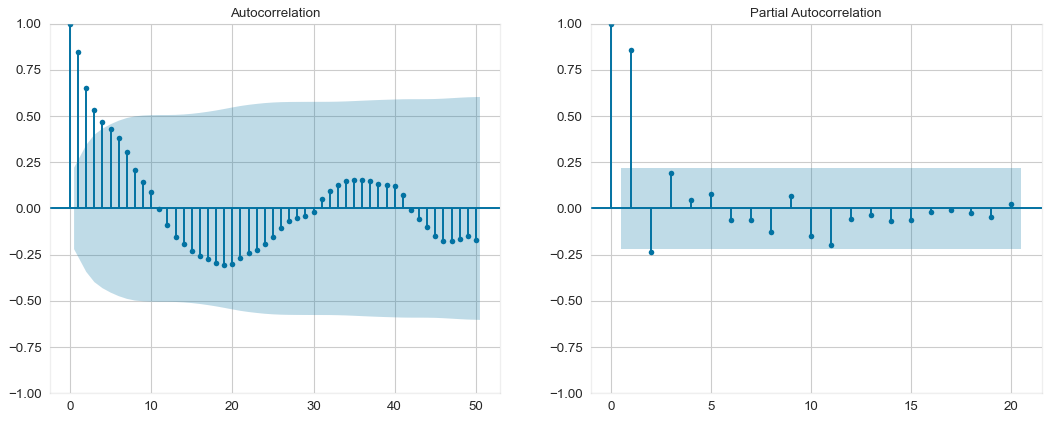

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi = 80)
plot_acf(temp['total'], ax=ax1, lags=50)
plot_pacf(temp['total'], ax=ax2, lags=20)

ax1.spines['top'].set_alpha(.3); ax2.spines['top'].set_alpha(.3)
ax1.spines['bottom'].set_alpha(.3); ax2.spines['bottom'].set_alpha(.3)
ax1.spines['right'].set_alpha(.3); ax2.spines['right'].set_alpha(.3)
ax1.spines['left'].set_alpha(.3); ax2.spines['left'].set_alpha(.3)

ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)

Creating 3 lags upper in the Feature Engineering

## 4.2 Bivariate Analysis

### 4.2.1 Revenue by the Time (weekly)

In [59]:
temp = pd.pivot_table(df_week, index=['year', 'week_of_year'], columns='airbnb_id', values='revenue', aggfunc='sum').reset_index().reset_index().rename(columns={'index':'weeks'})
temp.fillna(0, inplace=True)
temp['total'] = temp.drop(['weeks', 'year', 'week_of_year'], axis=1).sum(axis=1)

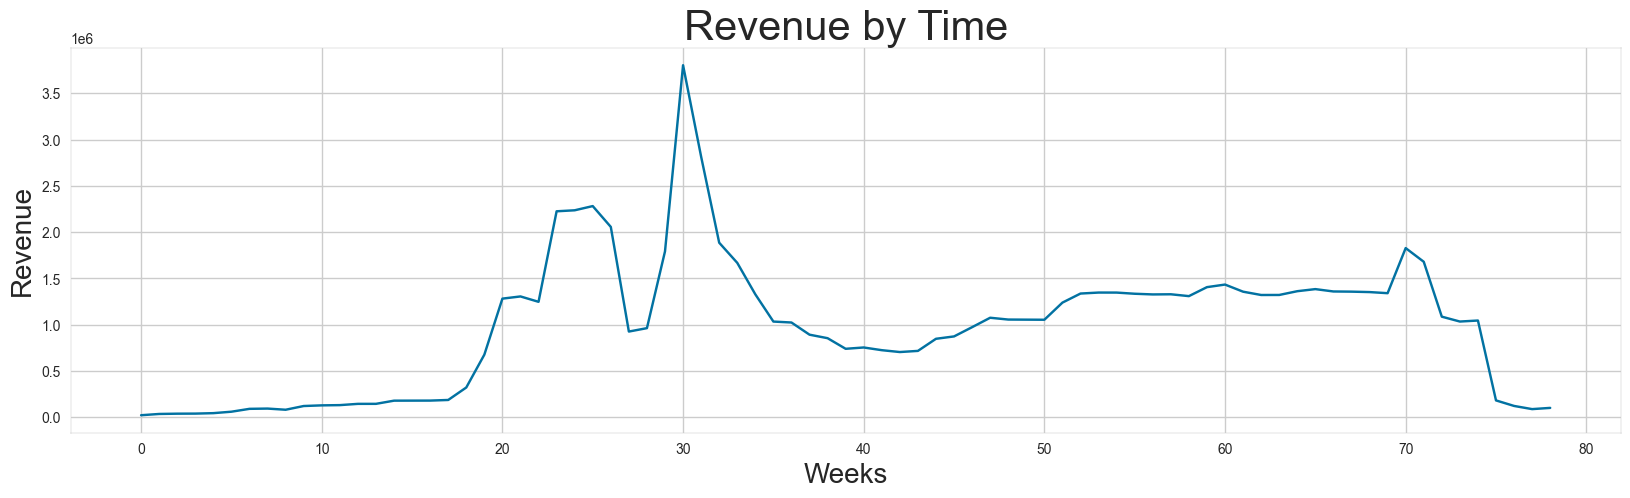

In [60]:
plt.figure(figsize=(20, 5))
ax = temp['total'].plot()
ax.spines['top'].set_alpha(.3)
ax.spines['bottom'].set_alpha(.3)
ax.spines['right'].set_alpha(.3)
ax.spines['left'].set_alpha(.3)
plt.title('Revenue by Time', fontsize=30)
plt.xlabel('Weeks', fontsize=20)
plt.ylabel('Revenue', fontsize=20);

### 4.2.2 Months

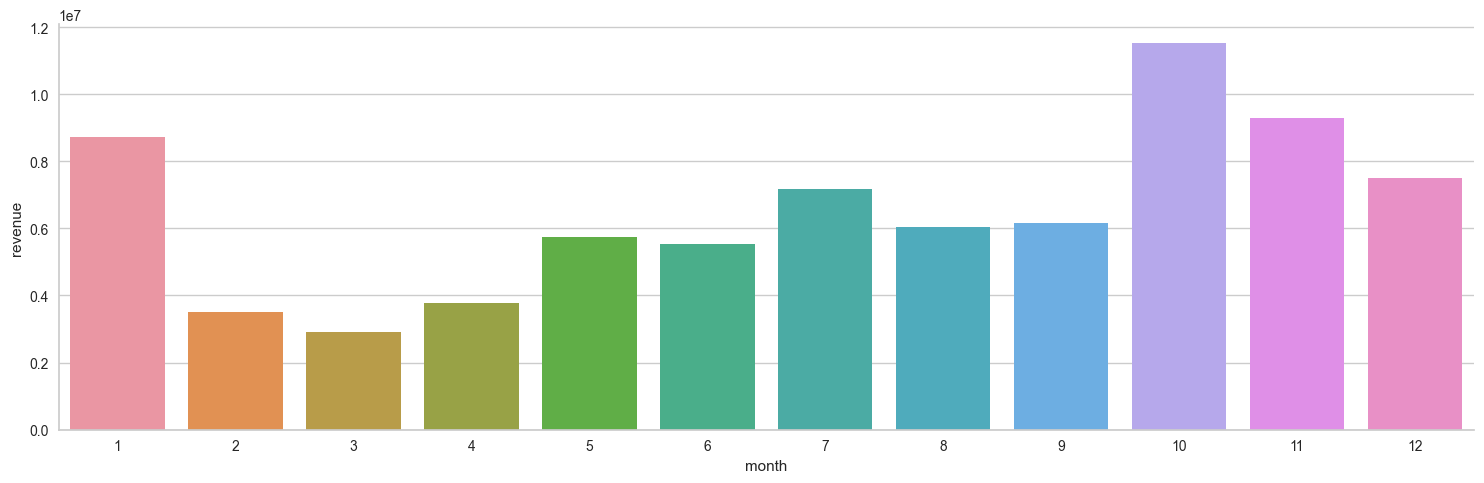

In [61]:
temp = df_week.groupby('month').agg({'revenue':'sum'}).reset_index()
sns.catplot(data=temp, x='month', y='revenue', kind='bar', aspect=3);

### 4.2.3 Weeks

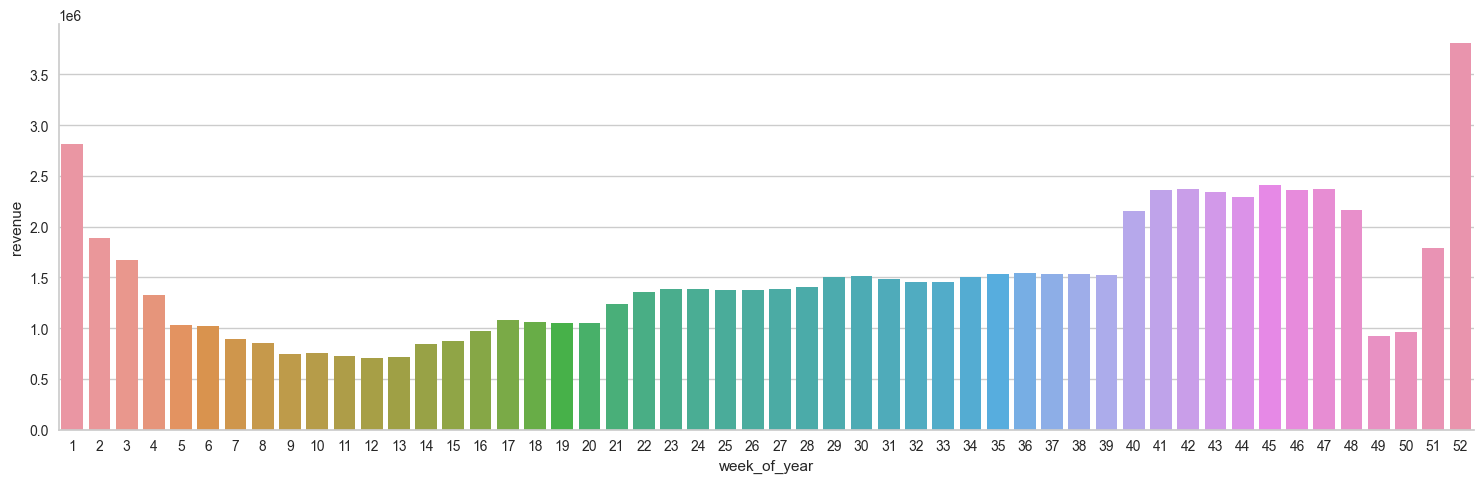

In [62]:
temp = df_week.groupby('week_of_year').agg({'revenue':'sum'}).reset_index()
sns.catplot(data=temp, x='week_of_year', y='revenue', kind='bar', aspect=3);

### 4.2.4 Years

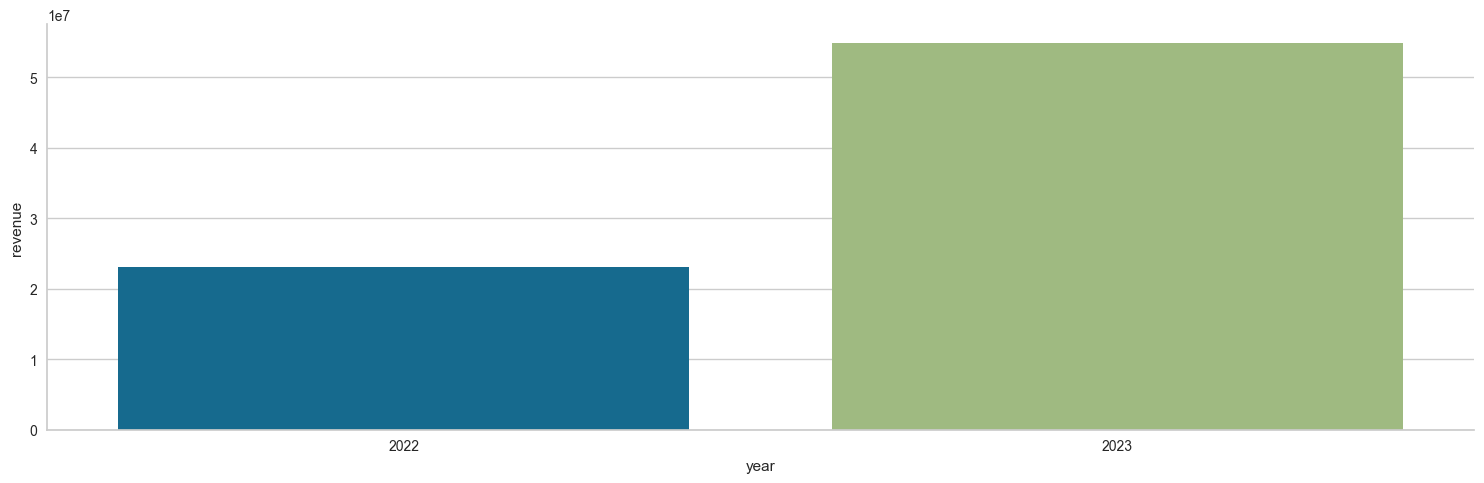

In [63]:
temp = df_week.groupby('year').agg({'revenue':'sum'}).reset_index()
sns.catplot(data=temp, x='year', y='revenue', kind='bar', aspect=3);

## 4.3 Multivariate Analysis

# 5.0 Data Preparation

## 5.1 Target

In [64]:
df_week['revenue'] = np.log1p(df_week['revenue'])

In [65]:
mm_revenue = pp.MinMaxScaler()
mm_revenue = mm_revenue.fit(df_week[['revenue']].values)
df_week['revenue'] = mm_revenue.transform(df_week[['revenue']].values)

## 5.2 Features

### 5.2.1 Normalization

### 5.2.2 Rescaling

### 5.2.3 Transformation

#### 5.2.3.1 Encoding

In [66]:
#  'airbnb_id',
map_airbnb_id = df_week.groupby('airbnb_id').agg({'available':'mean'})['available']
df_week['airbnb_id'] = df_week['airbnb_id'].map(map_airbnb_id)

#  'number_of_bathrooms',
map_number_of_bathrooms = df_week.groupby('number_of_bathrooms').agg({'available':'mean'})['available']
df_week['number_of_bathrooms'] = df_week['number_of_bathrooms'].map(map_number_of_bathrooms)

#  'number_of_bedrooms',
map_number_of_bedrooms = df_week.groupby('number_of_bedrooms').agg({'available':'mean'})['available']
df_week['number_of_bedrooms'] = df_week['number_of_bedrooms'].map(map_number_of_bedrooms)

#  'number_of_beds',
map_number_of_beds = df_week.groupby('number_of_beds').agg({'available':'mean'})['available']
df_week['number_of_beds'] = df_week['number_of_beds'].map(map_number_of_beds)

#  'number_of_guests',
map_number_of_guests = df_week.groupby('number_of_guests').agg({'available':'mean'})['available']
df_week['number_of_guests'] = df_week['number_of_guests'].map(map_number_of_guests)

#  'area'
map_area = df_week.groupby('area').agg({'available':'mean'})['available']
df_week['area'] = df_week['area'].map(map_area)

# 'neighborhood'
map_neighborhood = df_week.groupby('neighborhood').agg({'available':'mean'})['available']
df_week['neighborhood'] = df_week['neighborhood'].map(map_neighborhood)

# 'unit_type'
map_unit_type = df_week.groupby('unit_type').agg({'available':'mean'})['available']
df_week['unit_type'] = df_week['unit_type'].map(map_unit_type)

# 'year'
map_year = df_week.groupby('year').agg({'available':'mean'})['available']
df_week['year'] = df_week['year'].map(map_year)

#### 5.2.3.2 Nature Transformation

In [67]:
# week_of_year
week_of_year_cicle = df_week['week_of_year'].max() - df_week['week_of_year'].min() + 1
df_week['week_of_year_sin'] = df_week['week_of_year'].apply(lambda x: np.sin(x*(2*np.pi/week_of_year_cicle)))
df_week['week_of_year_cos'] = df_week['week_of_year'].apply(lambda x: np.cos(x*(2*np.pi/week_of_year_cicle)))
df_week.drop('week_of_year', axis=1, inplace=True)

# day
day_cicle = df_week['day'].max() - df_week['day'].min() + 1
df_week['day_sin'] = df_week['day'].apply(lambda x: np.sin(x*(2*np.pi/day_cicle)))
df_week['day_cos'] = df_week['day'].apply(lambda x: np.cos(x*(2*np.pi/day_cicle)))
df_week.drop('day', axis=1, inplace=True)

# month
month_cicle = df_week['month'].max() - df_week['month'].min() + 1
df_week['month_sin'] = df_week['month'].apply(lambda x: np.sin(x*(2*np.pi/month_cicle)))
df_week['month_cos'] = df_week['month'].apply(lambda x: np.cos(x*(2*np.pi/month_cicle)))
df_week.drop('month', axis=1, inplace=True)

## 5.3 PCA

In [68]:
# safety_features
pca_safety_features = PCA(n_components=1)
cols_safety_features = ['extintordeincendio', 'detectordefumaça', 'alarmedemonoxidodecarbono', 'kitdeprimeirossocorros']
pca_safety_features = pca_safety_features.fit(df_week[cols_safety_features].values)
safety_features = pca_safety_features.transform(df_week[cols_safety_features])
df_week['safety_features'] = safety_features
# df_week.drop(cols_safety_features, axis=1, inplace=True)

# amenities
pca_amenities = PCA(n_components=1)
cols_amenities = ['MáquinadeLavar', 'TV', 'Arcondicionado', 'WiFi', 'Cozinha', 'Churrasqueira', 'Estacionamentoincluído', 'Chuveiroexterno', 'Elevador', 'Ferrodepassar']
pca_amenities = pca_amenities.fit(df_week[cols_amenities].values)
amenities = pca_amenities.transform(df_week[cols_amenities])
df_week['amenities'] = amenities
# df_week.drop(cols_amenities, axis=1, inplace=True)

D:\My Drive\Pessoal\environments\seazone\lib\site-packages\sklearn\base.py:402: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
D:\My Drive\Pessoal\environments\seazone\lib\site-packages\sklearn\base.py:402: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


## 5.4 Preprocessing

### 5.4.1 Splits

#### 5.4.1.1 df_ref

In [69]:
df_ref.dropna(inplace=True)
X_ref = df_ref[['gross_revenue', 'recency', 'frequency']]

#### 5.4.1.2 df_week

In [70]:
# fillout NA
df_week.dropna(inplace=True)

In [71]:
# Train and Validation
X_train = df_week.loc[df_week['date'] < df_week['date'].max() - pd.Timedelta(6, 'w')].drop(['revenue', 'date', 'available'], axis=1).values
y_train = df_week.loc[df_week['date'] < df_week['date'].max() - pd.Timedelta(6, 'w'), 'revenue'].values.ravel()

X_test = df_week.loc[df_week['date'] >= df_week['date'].max() - pd.Timedelta(6, 'w')].drop(['revenue', 'date', 'available'], axis=1).values
y_test = df_week.loc[df_week['date'] >= df_week['date'].max() - pd.Timedelta(6, 'w'), 'revenue'].values.ravel()

# 6.0 Feature Selection

## 6.1 Wrapper Method

### 6.1.1 RFE

In [72]:
# rfe_fit = RFE(RandomForestRegressor(n_estimators=100, min_samples_leaf=100), n_features_to_select=1).fit(X_train, y_train)
# pickle.dump(rfe_fit, open('D:\\My Drive\\Pessoal\\Projetos\\seazone_code_challenge\\data\\interim\\rfe_fit.pkl', 'wb'))
# time.sleep(30)
rfe_fit = pickle.load(open('D:\\My Drive\\Pessoal\\Projetos\\seazone_code_challenge\\data\\interim\\rfe_fit.pkl', 'rb'))

rfe_ranking = rfe_fit.ranking_

ix = df_week.drop(['revenue', 'date', 'available'], axis=1).columns

feature_selection = pd.DataFrame(rfe_ranking, index=ix, columns=['rfe']).sort_values('rfe')

### 6.1.2 Boruta

In [73]:
# boruta_fit = BorutaPy(RandomForestRegressor(n_estimators=100, min_samples_leaf=100)).fit(X_train, y_train)
# pickle.dump(boruta_fit, open('D:\\My Drive\\Pessoal\\Projetos\\seazone_code_challenge\\data\\interim\\boruta.pkl', 'wb'))
# time.sleep(30)
boruta = pickle.load(open('D:\\My Drive\\Pessoal\\Projetos\\seazone_code_challenge\\data\\interim\\boruta.pkl', 'rb'))
boruta_ranking = boruta.ranking_
boruta_support = boruta.support_
feature_selection['boruta_rank'] = boruta_ranking

## 6.2 Importances

### 6.2.1 Random Forest

MAE: 842.1240730088755
MAPE: 0.3277338893135323
RMSE: 1872.9059271001136


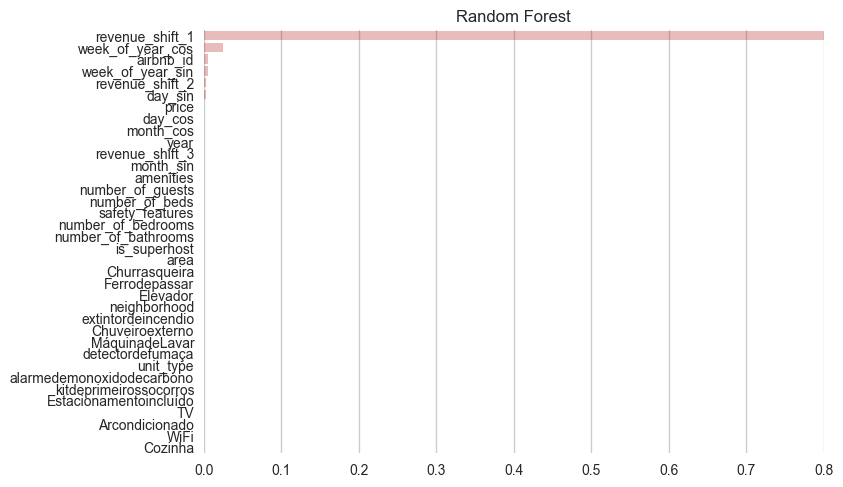

In [74]:
# model definition
rf_model = RandomForestRegressor(n_estimators=100, min_samples_leaf=1000, max_depth=5)

# fiting model
rf_fit = rf_model.fit(X_train, y_train)

# predicting
y_hat = rf_fit.predict(X_test)

# # metrics
metrics(y_test, y_hat)

rf_importances = rf_fit.feature_importances_

ix = df_week.drop(['revenue','airbnb_id', 'date', 'available'], axis=1).columns

feature_selection['rf_importances'] = rf_importances

sns.barplot(data=feature_selection.sort_values('rf_importances', ascending=False), x='rf_importances', y=feature_selection.index, color='r', alpha=0.3)
sns.despine(left=True, bottom=True)
plt.title('Random Forest')
plt.xlabel('')
plt.ylabel('')
plt.xlim(0, 0.8);

overfitado

### 6.2.2 XGBoostRegressor

MAE: 1092.6222421254047
MAPE: 0.42522158959640244
RMSE: 2350.079173174081


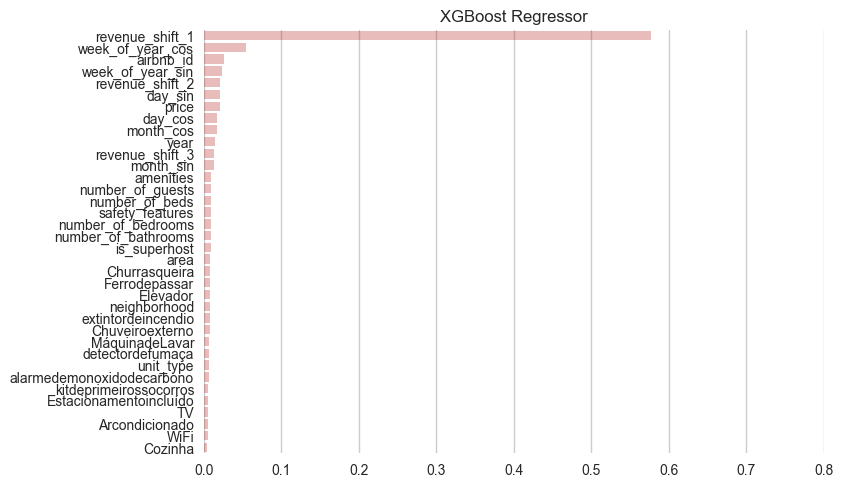

In [75]:
# model definition
xgb_model = XGBRegressor()

# fiting model
xgb_fit = xgb_model.fit(X_train, y_train)

# predicting
y_hat = xgb_fit.predict(X_test)

# # metrics
metrics(y_test, y_hat)

xgb_importances = xgb_fit.feature_importances_

ix = df_week.drop(['revenue','airbnb_id', 'date', 'available'], axis=1).columns

feature_selection['xgb_importances'] = xgb_importances

sns.barplot(data=feature_selection.sort_values('xgb_importances', ascending=False), x='xgb_importances', y=feature_selection.index, color='r', alpha=0.3)
sns.despine(left=True, bottom=True)
plt.title('XGBoost Regressor')
plt.xlabel('')
plt.ylabel('')
plt.xlim(0, 0.8);

## 6.3 Correlations

In [76]:
feature_selection['corr'] = np.abs(df_week.corr()['revenue'].drop(['revenue', 'available']).values
)
np.abs(df_week.corr()['revenue'].drop(['airbnb_id', 'revenue', 'available'])).sort_values(ascending=False)

C:\Users\Samoel\AppData\Local\Temp\ipykernel_9768\2723438938.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  feature_selection['corr'] = np.abs(df_week.corr()['revenue'].drop(['revenue', 'available']).values
C:\Users\Samoel\AppData\Local\Temp\ipykernel_9768\2723438938.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  np.abs(df_week.corr()['revenue'].drop(['airbnb_id', 'revenue', 'available'])).sort_values(ascending=False)


revenue_shift_1              0.620649
revenue_shift_2              0.540386
revenue_shift_3              0.493132
week_of_year_sin             0.197089
month_sin                    0.177442
year                         0.175073
month_cos                    0.133341
is_superhost                 0.119601
neighborhood                 0.103381
week_of_year_cos             0.102411
amenities                    0.093229
number_of_beds               0.079588
Ferrodepassar                0.077214
number_of_guests             0.075993
Arcondicionado               0.071056
number_of_bedrooms           0.068782
area                         0.067563
TV                           0.065260
MáquinadeLavar               0.058970
kitdeprimeirossocorros       0.052779
Churrasqueira                0.051558
price                        0.050726
Elevador                     0.050487
Chuveiroexterno              0.043033
day_cos                      0.033502
Estacionamentoincluído       0.031152
day_sin     

## 6.3 Selections

In [77]:
feature_selection

,rfe,boruta_rank,rf_importances,xgb_importances,corr
revenue_shift_1,1,1,5.816563e-03,0.021393,0.625678
week_of_year_cos,2,4,0.000000e+00,0.007245,0.067563
airbnb_id,3,1,5.550728e-03,0.012622,0.050726
week_of_year_sin,4,6,0.000000e+00,0.005466,0.068782
revenue_shift_2,5,3,0.000000e+00,0.008117,0.001028
day_sin,6,5,0.000000e+00,0.009035,0.079588
price,7,2,0.000000e+00,0.007476,0.075993
day_cos,8,13,0.000000e+00,0.006938,0.017020
month_cos,9,17,0.000000e+00,0.005453,0.004773
year,10,19,0.000000e+00,0.007896,0.005317


# 7.0 ML Clustering Model

## 7.1 Sample Space

### 7.1.1 T-SNE

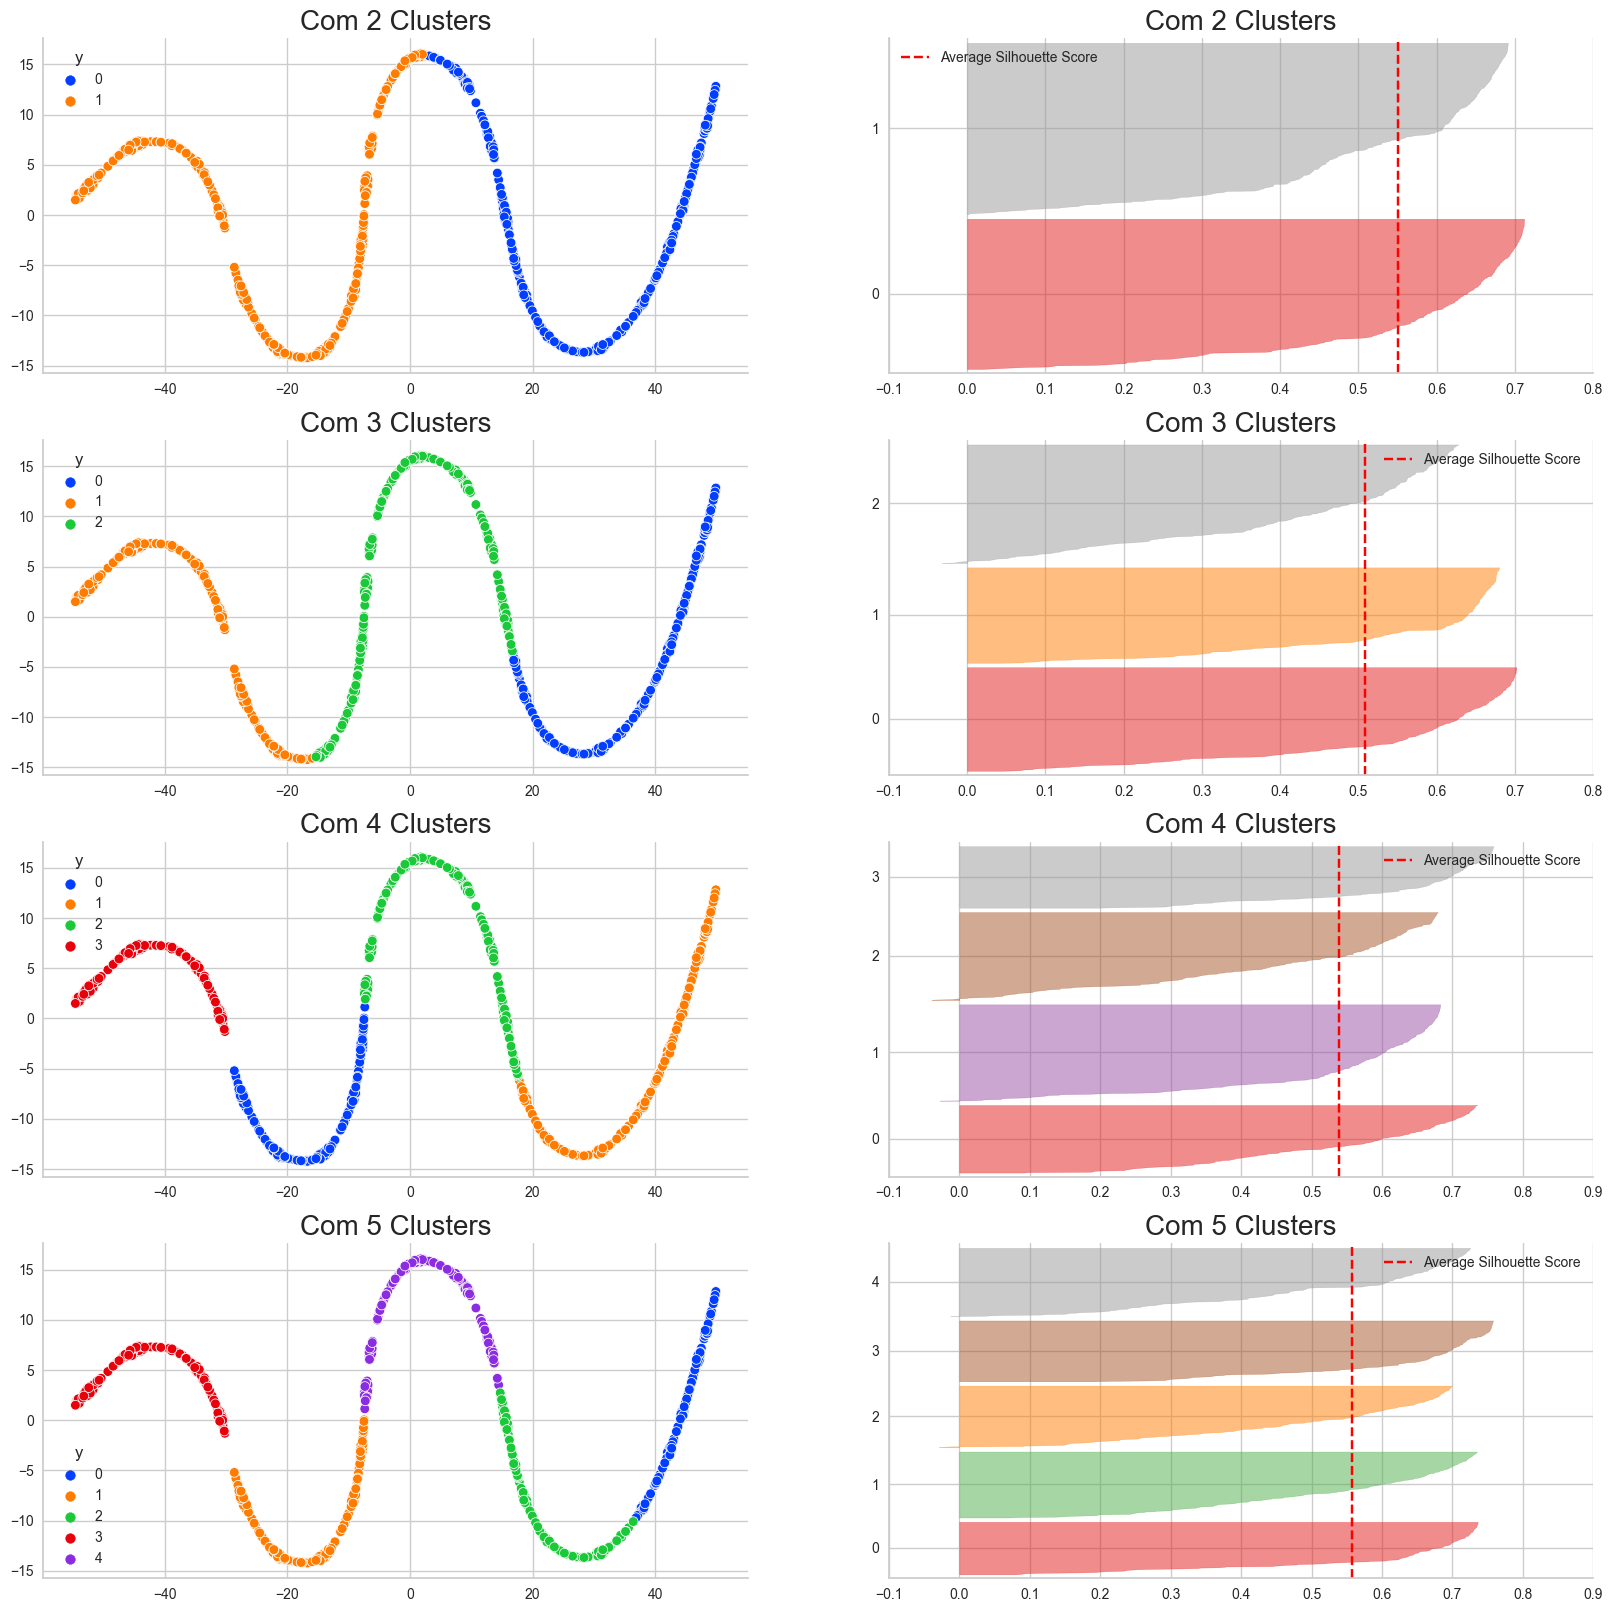

In [78]:
# model definition
reducer = TSNE(random_state=100, n_components=2, n_jobs=-1)
embedding = reducer.fit_transform(X_ref)

# embedding
X_ = pd.DataFrame()
X_[0] = embedding[:, 0]
X_[1] = embedding[:, 1]

clusters = [2, 3, 4, 5]

plt.figure(figsize=(20, 20))
for j, i in enumerate(clusters):
    j = j + 1
    j = j * 2
    # model definition
    kmeans = c.KMeans(n_clusters=i,
                      init='k-means++',
                      n_init=10,
                      max_iter=300,
                      random_state=100)
    # model training
    kmeans.fit(X_[[0, 1]])
    X_['y'] = kmeans.labels_
    
    # dot plot
    plt.subplot(4, 2, j - 1)
    sns.scatterplot(data=X_, x=0, y=1, hue='y', palette="bright")
    plt.title(f'Com {i} Clusters', fontsize=20)
    plt.xlabel('')
    plt.ylabel('')
    sns.despine()

    # silhouette visualizer
    plt.subplot(4, 2, j)
    visualizer = SilhouetteVisualizer(estimator=kmeans)
    visualizer.fit(X_[[0, 1]])
    visualizer.finalize()
    plt.title(f'Com {i} Clusters', fontsize=20)
    plt.xlabel('')
    plt.ylabel('')
    sns.despine()

## 7.2 Clustering Hyperparameter Fine-tuning

### 7.2.1 Within-Cluster Sum of Square (WSS)

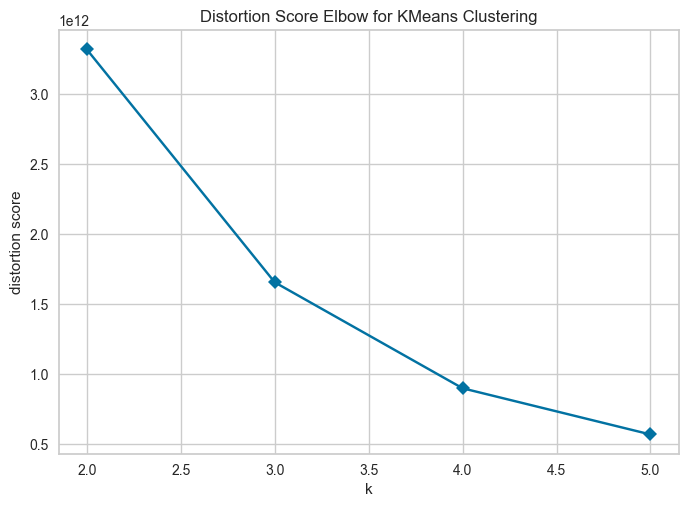

In [79]:
clusters = [2, 3, 4, 5]
kmeans = KElbowVisualizer(c.KMeans(n_init=10), k=clusters, timings=False, locate_elbow=False)
kmeans.fit(X_ref)
kmeans.show();

### 7.2.2 Silhouette Score

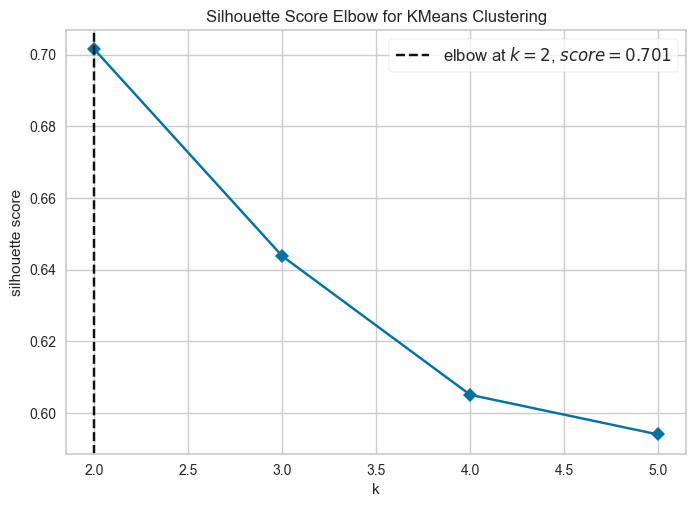

In [80]:
clusters = [2, 3, 4, 5]
kmeans = KElbowVisualizer(c.KMeans(n_init=10), metric='silhouette', k=clusters, timings=False)
kmeans.fit(X_ref)
kmeans.show();

## 7.3 Clustering Model Training

In [81]:
k = 2

# model definition
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=100)

# model training
kmeans.fit(X_ref)

# clustering
labels = kmeans.labels_
df_ref['cluster'] = labels

In [82]:
# WSS (Within-cluster sum of squares)
print(f'WSS value: {kmeans.inertia_}')

# SS (silhouette)
print(f'SS value: {m.silhouette_score(X_ref, labels, metric="euclidean")}')

WSS value: 3320692929213.395
SS value: 0.7014730205520308


## 7.4 Visual Inpection

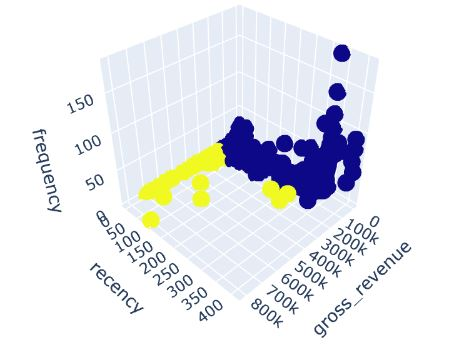

In [120]:
fig = px.scatter_3d(df_ref, x='gross_revenue', y='recency', z='frequency', color='cluster')
# fig.show()
Image('D:\\My Drive\\Pessoal\\Projetos\\seazone_code_challenge\\img\\3d_plot.jpg')

## 7.5 Cluster Profile

In [84]:
# Number of customers
profile = df_ref.groupby('cluster').agg({'airbnb_id':'count'}).reset_index().rename(columns={'airbnb_id':'number_of_customers'})
# Proportional number of customers
profile['prop_number_of_customers'] = profile['number_of_customers']  / np.sum(profile['number_of_customers'])
# Avg Gross Revenue
temp = df_ref.groupby('cluster').agg({'gross_revenue': 'mean'}).reset_index().rename(columns={'gross_revenue':'avg_gross_revenue'})
profile['avg_gross_revenue'] = temp['avg_gross_revenue']
# Proportional gross revenue
temp = df_ref.groupby('cluster').agg({'gross_revenue':'sum'}).reset_index().rename(columns={'gross_revenue':'sum_gross_revenue'})
profile['prop_gross_revenue'] = temp['sum_gross_revenue'] / np.sum(temp['sum_gross_revenue'])
# Avg Recency days
temp = df_ref.groupby('cluster').agg({'recency': 'mean'}).reset_index().rename(columns={'recency':'avg_recency_days'})
profile['avg_recency_days'] = temp['avg_recency_days']
# Avg Frequency
temp = df_ref.groupby('cluster').agg({'frequency': 'mean'}).reset_index().rename(columns={'frequency':'avg_frequency'})
profile['avg_frequency'] = temp['avg_frequency']
profile

,cluster,number_of_customers,prop_number_of_customers,avg_gross_revenue,prop_gross_revenue,avg_recency_days,avg_frequency
0,0,670,0.850254,63853.420896,0.549519,147.149254,12.903988
1,1,118,0.149746,297214.652542,0.450481,10.313559,1.941855


###### Cluster 0
* Number of customers: 670 (85% of total)
* 55% of total gross revenue
* Avarage gross revenue: 63853.42
* Avarage Recency: 147 days
* Average frequency every 13 days

###### Cluster 1
* Number of customers: 118	 (15% of total)
* 45% of total gross revenue
* Avarage gross revenue: 297214.65
* Avarage Recency: 10 days
* Average frequency every 2 days

## 7.5.1 Number of Bedrooms

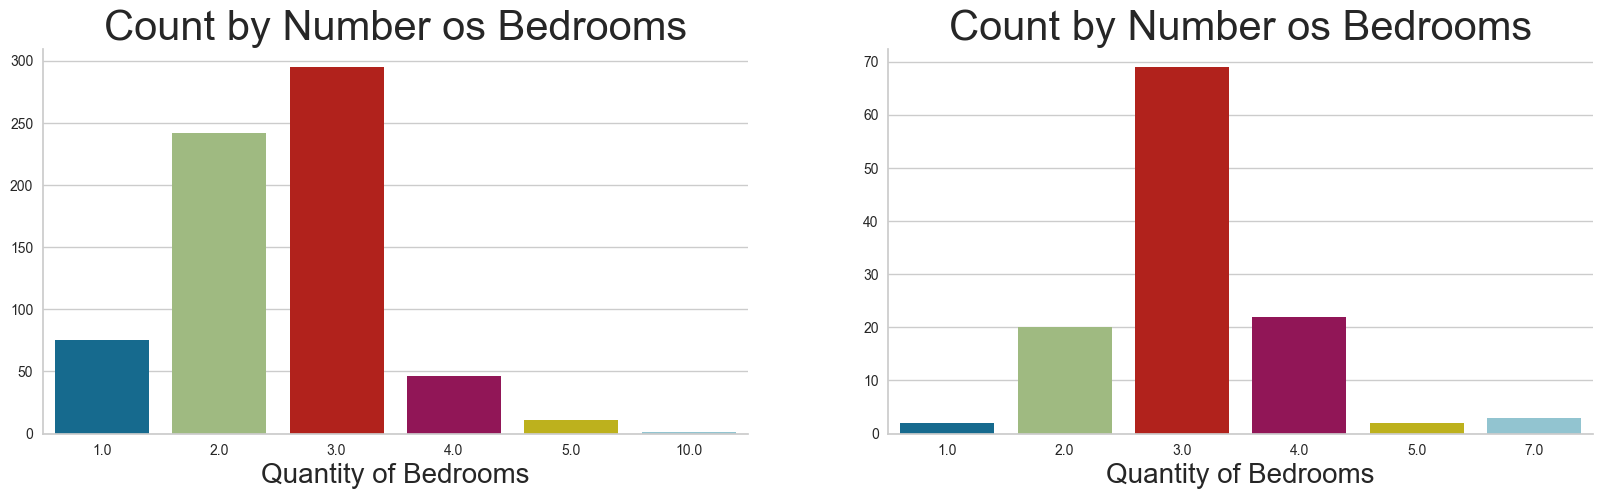

In [85]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
sns.countplot(data=df_ref.loc[df_ref['cluster']==0] , x='number_of_bedrooms')
plt.title('Count by Number os Bedrooms', fontsize=30)
plt.xlabel('Quantity of Bedrooms', fontsize=20)
plt.ylabel('')
sns.despine()
plt.subplot(1, 2, 2)
sns.countplot(data=df_ref.loc[df_ref['cluster']==1] , x='number_of_bedrooms')
plt.title('Count by Number os Bedrooms', fontsize=30)
plt.xlabel('Quantity of Bedrooms', fontsize=20)
plt.ylabel('')
sns.despine();

3 bedrooms

## 7.5.2 Number of Bathrooms

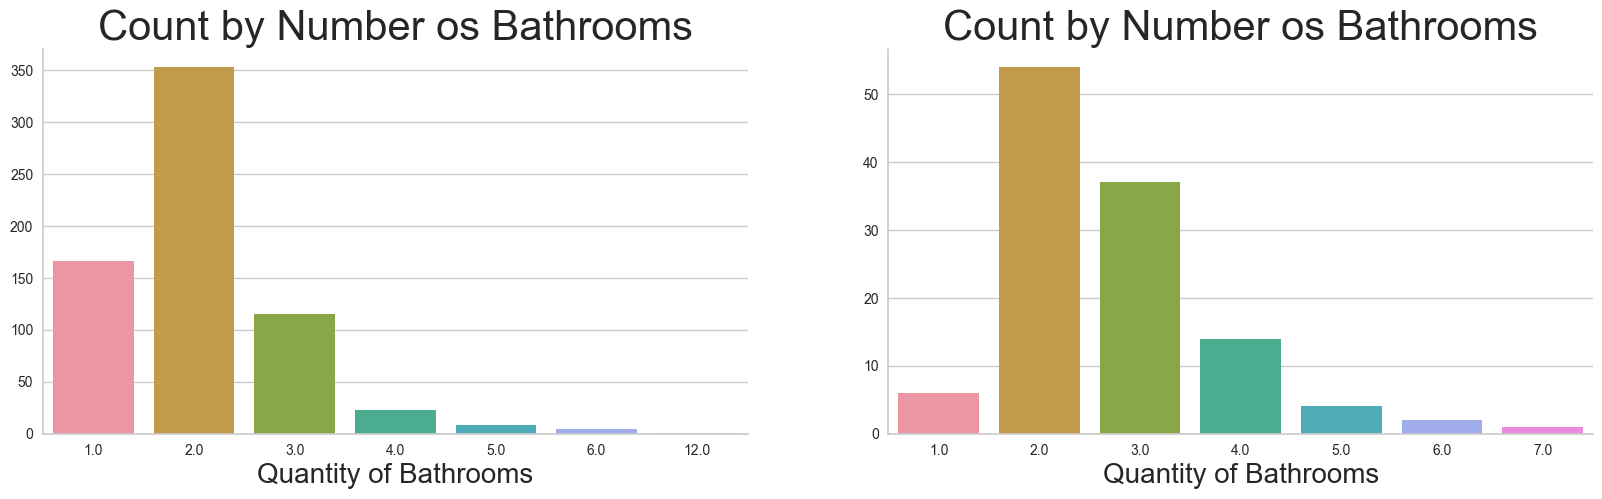

In [86]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
sns.countplot(data=df_ref.loc[df_ref['cluster']==0] , x='number_of_bathrooms')
plt.title('Count by Number os Bathrooms', fontsize=30)
plt.xlabel('Quantity of Bathrooms', fontsize=20)
plt.ylabel('')
sns.despine()
plt.subplot(1, 2, 2)
sns.countplot(data=df_ref.loc[df_ref['cluster']==1] , x='number_of_bathrooms')
plt.title('Count by Number os Bathrooms', fontsize=30)
plt.xlabel('Quantity of Bathrooms', fontsize=20)
plt.ylabel('')
sns.despine();

2 bathrooms

## 7.5.3 Number of Beds

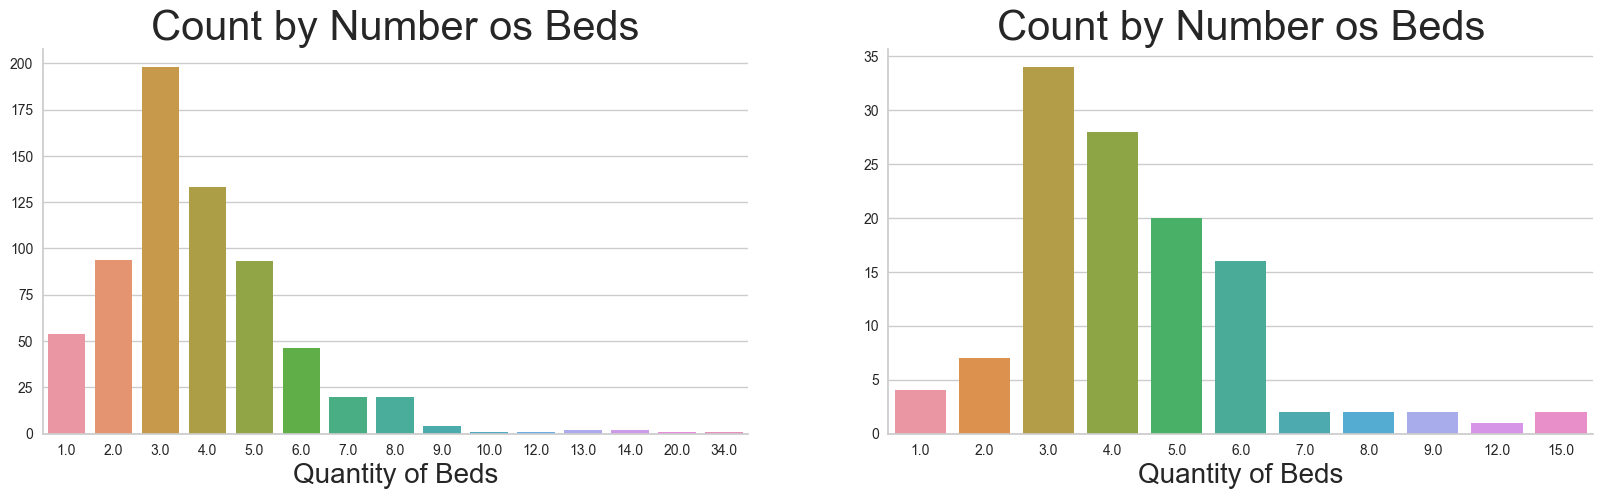

In [87]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
sns.countplot(data=df_ref.loc[df_ref['cluster']==0] , x='number_of_beds')
plt.title('Count by Number os Beds', fontsize=30)
plt.xlabel('Quantity of Beds', fontsize=20)
plt.ylabel('')
sns.despine()
plt.subplot(1, 2, 2)
sns.countplot(data=df_ref.loc[df_ref['cluster']==1] , x='number_of_beds')
plt.title('Count by Number os Beds', fontsize=30)
plt.xlabel('Quantity of Beds', fontsize=20)
plt.ylabel('')
sns.despine();

3 beds

## 7.5.4 Best Location in the City

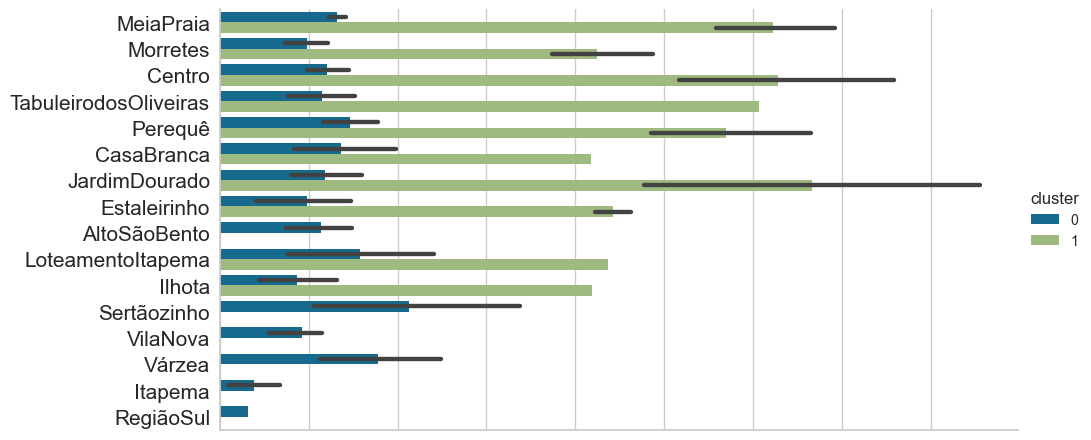

In [88]:
temp = df_ref.loc[df['number_of_bedrooms']==3]
ax = sns.catplot(data=temp, x='gross_revenue', y='neighborhood', hue='cluster', kind='bar', aspect=2, estimator='mean')
ax.tick_params(labelbottom=False, labelsize=15)
plt.ylabel('')
plt.xlabel('');

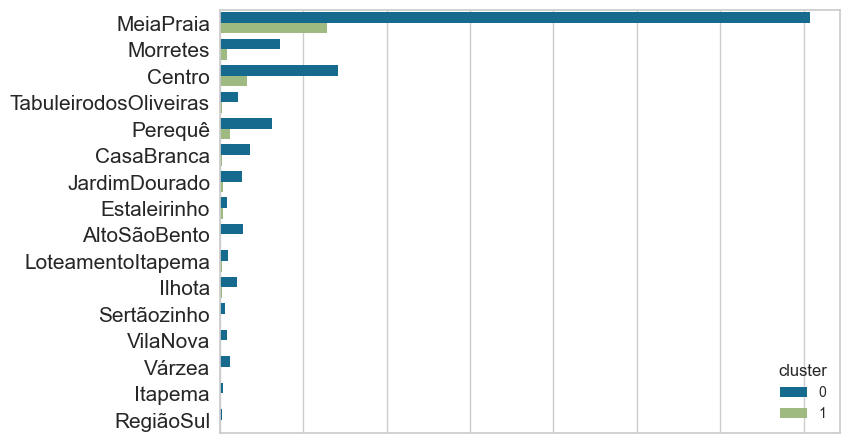

In [89]:
ax = sns.countplot(data=temp, y='neighborhood', hue='cluster')
ax.tick_params(labelbottom=False, labelsize=15)
plt.ylabel('')
plt.xlabel('');

In [125]:
temp = df_ref.groupby('neighborhood').agg({'frequency':'mean', 'gross_revenue':'mean', 'cluster':['mean', 'count']}).reset_index()
temp.columns = 'neighborhood frequency gross_revenue cluster count'.split()
temp = temp.sort_values('cluster', ascending=False)
temp['neighborhood'] = temp['neighborhood'].apply(lambda x: x.replace(' ', '').lower())
temp['neighborhood'] = temp['neighborhood'].apply(lambda x: unidecode(x))

temp1 = vivareal.loc[(vivareal['bedrooms']==3)&(vivareal['bathrooms']==2)]
temp1 = temp1.groupby('neighborhood').agg({'sale_price':'mean'}).reset_index().sort_values('sale_price')
temp1['sale_price'] = temp1['sale_price'].round()
temp1['neighborhood'] = temp1['neighborhood'].apply(lambda x: x.replace(' ', '').lower())

temp = pd.merge(temp, temp1, on='neighborhood', how='left')
temp['yearly_roi'] = temp['gross_revenue'] / temp['sale_price'] * (365/date_delta)
temp.sort_values('yearly_roi', ascending=False, inplace=True)
temp

,neighborhood,frequency,gross_revenue,cluster,count,sale_price,yearly_roi
6,casabranca,11.219963,107292.291667,0.125000,24,590526.0,0.120795
15,varzea,4.913502,80253.142857,0.000000,7,612702.0,0.087083
9,tabuleirodosoliveiras,10.341238,79805.062500,0.062500,16,713699.0,0.074342
8,morretes,12.510798,72361.125000,0.125000,48,684595.0,0.070274
4,meiapraia,11.363045,103379.496802,0.155650,469,1099178.0,0.062530
3,centro,10.151434,101007.592233,0.165049,103,1099498.0,0.061077
10,altosaobento,12.791130,56688.785714,0.000000,14,696840.0,0.054086
2,ilhota,25.998080,78306.000000,0.166667,12,1650000.0,0.031552
0,estaleirinho,13.317405,123382.000000,0.428571,7,NaN,NaN
1,pereque,9.014160,112356.727273,0.204545,44,NaN,NaN


for investment at Casa Branca
for 50 apartments at Meia Praia

## 7.5.5 Unit Type

In [91]:
temp = df_ref.loc[df_ref['cluster']==1]
temp.groupby('unit_type').agg({'revenue':'mean'}).reset_index()

,unit_type,revenue
0,APARTMENT,807.524272
1,HOME,835.333333


In [92]:
temp = vivareal.groupby('unit_type').agg({'sale_price':'mean'}).reset_index()
temp['sale_price'] = round(temp['sale_price'])
temp.sort_values('sale_price')

,unit_type,sale_price
11,RESIDENTIAL_ALLOTMENT_LAND,224385.0
12,RESIDENTIAL_BUILDING,340000.0
7,FLAT,588109.0
3,COMMERCIAL_BUILDING,769190.0
2,BUSINESS,1010777.0
13,TWO_STORY_HOUSE,1050000.0
9,OFFICE,1401784.0
1,BUILDING,1500000.0
4,COMMERCIAL_PROPERTY,1895866.0
8,HOME,1907634.0


## 7.5.6 Safety Features

In [93]:
df_ref.groupby('cluster').agg({'extintordeincendio':'mean', 'detectordefumaça':'mean', 'alarmedemonoxidodecarbono':'mean', 'kitdeprimeirossocorros':'mean'}).T

cluster,0,1
extintordeincendio,0.485075,0.652542
detectordefumaça,0.122388,0.161017
alarmedemonoxidodecarbono,0.073134,0.033898
kitdeprimeirossocorros,0.043284,0.110169


Fire Extinguisher and First Aid Kit are important

## 7.5.7 Amenities

In [94]:
df_ref.groupby('cluster').agg({'MáquinadeLavar':'mean', 'TV':'mean', 'Arcondicionado':'mean', 'WiFi':'mean', 'Cozinha':'mean', 'Churrasqueira':'mean', 'Estacionamentoincluído':'mean', 'Chuveiroexterno':'mean', 'Elevador':'mean', 'Ferrodepassar':'mean'}).T

cluster,0,1
MáquinadeLavar,0.873134,0.966102
TV,0.977612,0.983051
Arcondicionado,0.952239,0.991525
WiFi,0.970149,0.966102
Cozinha,0.968657,1.000000
Churrasqueira,0.574627,0.728814
Estacionamentoincluído,0.922388,0.991525
Chuveiroexterno,0.141791,0.152542
Elevador,0.505970,0.728814
Ferrodepassar,0.722388,0.737288


With the exception of outdoor shower, all items are interesting. Especially elevator and barbecue

## 7.5.8 Super Host

In [95]:
df_ref.groupby('is_superhost').agg({'revenue':'mean'})

,revenue
is_superhost,
0.0,213.879046
1.0,242.049751


In [96]:
df_ref.groupby('cluster').agg({'is_superhost':'mean'})

,is_superhost
cluster,
0,0.258209
1,0.237288


In [97]:
df_ref[['cluster', 'is_superhost']].corr()

,cluster,is_superhost
cluster,1.000000,-0.017125
is_superhost,-0.017125,1.000000


A clusterizaão deste projeto não tem nenhuma correlação com a categoria "superhost"

# 8.0 Machine Learning Regressor

## 8.1 Preprocessing

In [98]:
cols_selected = df_week.drop(cols_safety_features+cols_amenities, axis=1).columns

# cols_selected = ['number_of_bedrooms', 'number_of_bathrooms', 'number_of_beds', 'extintordeincendio', 'kitdeprimeirossocorros', 'MáquinadeLavar', 'Elevador', 'revenue', 'available', 'neighborhood', 'unit_type', 'date', 'year', 'week_of_year_sin', 'week_of_year_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos']

In [99]:
# Train and Validation
X_train = df_week[cols_selected].loc[df_week['date'] < df_week['date'].max() - pd.Timedelta(6, 'w')].drop(['revenue', 'date'], axis=1).values
y_train = df_week[cols_selected].loc[df_week['date'] < df_week['date'].max() - pd.Timedelta(6, 'w'), 'revenue'].values.ravel()

X_test = df_week[cols_selected].loc[df_week['date'] >= df_week['date'].max() - pd.Timedelta(6, 'w')].drop(['revenue', 'date'], axis=1).values
y_test = df_week[cols_selected].loc[df_week['date'] >= df_week['date'].max() - pd.Timedelta(6, 'w'), 'revenue'].values.ravel()

## 8.2 Models

### 8.2.1 Linear Regression

In [100]:
# model definition
lr_model = LinearRegression()

# fiting model
lr_fit = lr_model.fit(X_train, y_train)

# predicting
y_hat = lr_fit.predict(X_test)

# # metrics
metrics(y_test, y_hat)

MAE: 2415.476201043711
MAPE: 0.9400436767991406
RMSE: 6670.575019800271


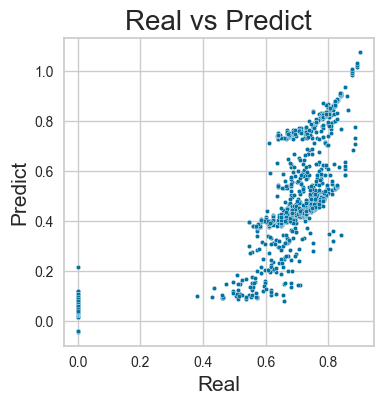

In [101]:
plt.figure(figsize=(4, 4))
sns.scatterplot(x=y_test, y=y_hat, s=10)
plt.title('Real vs Predict', fontsize=20)
plt.xlabel('Real', fontsize=15)
plt.ylabel('Predict', fontsize=15);

#### 8.2.1.1 Cross Validation

In [102]:
error = pd.DataFrame()
error, lr_cross_validation_metrics = cross_validation(df_week, cols_selected, error, 5, 'Linear Regression', lr_model)

lr_cross_validation_metrics.T

,MAE,MAPE,RMSE
Fold: 5,2704.526601,1.803018,8154.83432
Fold: 4,3551.490761,2.039917,13092.52763
Fold: 3,2398.046461,1.325549,9946.57944
Fold: 2,1563.409594,0.730713,4009.458432
Fold: 1,2415.476201,0.940044,6670.57502
mean_and_std,2526.59 +/- 638.54,1.37 +/- 0.5,8374.79 +/- 3057.33


### 8.2.2 Lasso

In [103]:
# model definition
lasso_model = Lasso()

# fiting model
lasso_fit = lasso_model.fit(X_train, y_train)

# predicting
y_hat = lasso_fit.predict(X_test)

# # metrics
metrics(y_test, y_hat)

MAE: 4441271.509113
MAPE: 1728.4331749101345
RMSE: 79493259.03796363


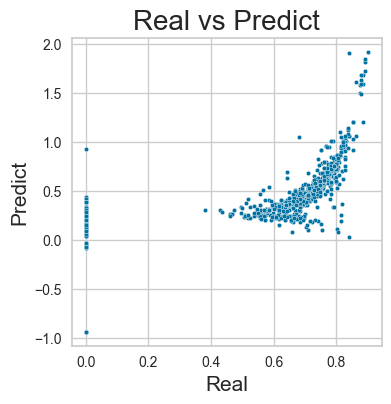

In [104]:
plt.figure(figsize=(4, 4))
sns.scatterplot(x=y_test, y=y_hat, s=10)
plt.title('Real vs Predict', fontsize=20)
plt.xlabel('Real', fontsize=15)
plt.ylabel('Predict', fontsize=15);

#### 8.2.2.1 Cross Validation

In [105]:
error, lasso_cross_validation_metrics = cross_validation(df_week, cols_selected, error, 5, 'Lasso', lasso_model)

lasso_cross_validation_metrics.T

,MAE,MAPE,RMSE
Fold: 5,36258.72669,24.172487,909154.319799
Fold: 4,1031733.943901,592.610774,66833587.348078
Fold: 3,40165577.77599,22201.997781,2301734114.691451
Fold: 2,2614242.36837,1221.855426,152443849.519547
Fold: 1,4441271.509113,1728.433175,79493259.037964
mean_and_std,9657816.86 +/- 15326652.93,5153.81 +/- 8543.44,520282792.98 +/- 892024088.44


### 8.2.3 Random Forest Regressor

In [106]:
# model definition
rf_model = RandomForestRegressor(n_estimators=100, min_samples_leaf=100)

# fiting model
rf_fit = rf_model.fit(X_train, y_train)

# predicting
y_hat = rf_fit.predict(X_test)

# # metrics
metrics(y_test, y_hat)

MAE: 344.9463709009382
MAPE: 0.13424460760993023
RMSE: 843.7540763621254


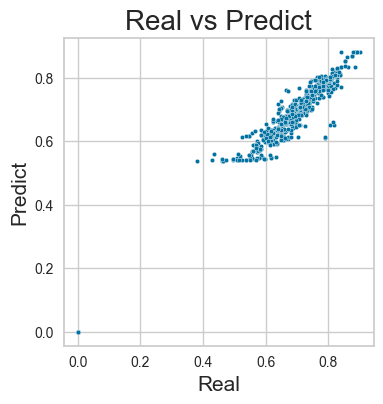

In [107]:
plt.figure(figsize=(4, 4))
sns.scatterplot(x=y_test, y=y_hat, s=10)
plt.title('Real vs Predict', fontsize=20)
plt.xlabel('Real', fontsize=15)
plt.ylabel('Predict', fontsize=15);

#### 8.2.3.1 Cross Validation

In [108]:
error, rf_cross_validation_metrics = cross_validation(df_week, cols_selected, error, 5, 'Random Forest', rf_model)

rf_cross_validation_metrics.T

,MAE,MAPE,RMSE
Fold: 5,85.636608,0.057091,392.572485
Fold: 4,106.821188,0.061356,408.591419
Fold: 3,97.192588,0.053724,339.872344
Fold: 2,231.049318,0.107989,776.789137
Fold: 1,345.154655,0.134326,840.770846
mean_and_std,173.17 +/- 100.76,0.08 +/- 0.03,551.72 +/- 212.08


### 8.2.4 XGBoost Regressor

In [109]:
# model definition
xgb_model = XGBRegressor()

# fiting model
xgb_fit = xgb_model.fit(X_train, y_train)

# predicting
y_hat = xgb_fit.predict(X_test)

# # metrics
metrics(y_test, y_hat)

MAE: 338.1047250926961
MAPE: 0.1315820080454393
RMSE: 772.1018995545589


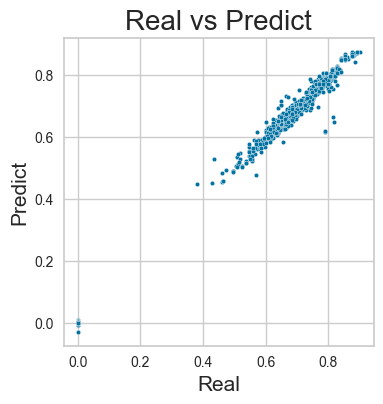

In [110]:
plt.figure(figsize=(4, 4))
sns.scatterplot(x=y_test, y=y_hat, s=10)
plt.title('Real vs Predict', fontsize=20)
plt.xlabel('Real', fontsize=15)
plt.ylabel('Predict', fontsize=15);

#### 8.2.4.1 Cross Validation

In [111]:
error, xgb_cross_validation_metrics = cross_validation(df_week, cols_selected, error, 5, 'XGBoost Regressor', xgb_model)

xgb_cross_validation_metrics.T

,MAE,MAPE,RMSE
Fold: 5,238.773689,0.159182,649.698495
Fold: 4,627.060245,0.360173,1437.261471
Fold: 3,1014.863369,0.560978,1828.502798
Fold: 2,303.329946,0.141772,730.451967
Fold: 1,338.104725,0.131582,772.1019
mean_and_std,504.43 +/- 287.84,0.27 +/- 0.17,1083.6 +/- 466.9


## 8.3 Model Performance

In [112]:
error.T

,MAE,MAPE,RMSE
Linear Regression,2526.59 +/- 638.54,1.37 +/- 0.5,8374.79 +/- 3057.33
Lasso,9657816.86 +/- 15326652.93,5153.81 +/- 8543.44,520282792.98 +/- 892024088.44
Random Forest,173.17 +/- 100.76,0.08 +/- 0.03,551.72 +/- 212.08
XGBoost Regressor,504.43 +/- 287.84,0.27 +/- 0.17,1083.6 +/- 466.9


# 10.0 Business Performance

## 10.1 Mean Aproach

apartment in Meia Praia, with 3 bedrooms and 2 bathrooms.

In [113]:
temp = df_ref[(df_ref['number_of_bedrooms']==3)&(df_ref['number_of_bathrooms']==2)&(df_ref['neighborhood']=='MeiaPraia')&(df_ref['unit_type']=='APARTMENT')]

In [114]:
gross_revenue_mean = temp['gross_revenue'].mean()
print(f'Properties with this configuration has AVG Gross Revenue: R${round(gross_revenue_mean, 2)} 2022-06-02 since at 2023-12-02')

Properties with this configuration has AVG Gross Revenue: R$97630.08 2022-06-02 since at 2023-12-02


In [115]:
gross_revenue_day = gross_revenue_mean / date_delta
print(f'Properties with this configuration has AVG Gross Revenue: R${round(gross_revenue_day, 2)} per day')

Properties with this configuration has AVG Gross Revenue: R$177.83 per day


In [116]:
gross_revenue_2_years_along = gross_revenue_day * (365*3)
print(f'Properties with this configuration will be generate: R${round(gross_revenue_2_years_along, 2)} over the years 2024 and 2025')

Properties with this configuration will be generate: R$194726.66 over the years 2024 and 2025


In [117]:
print(f'For 50 properties like that: R${round(180920.28 * 50)}')

For 50 properties like that: R$9046014


## 10.2 Predict Aproach

# Time

In [118]:
print(f'Total processing time: {round((time.time() - time_init) / 60, 1)} minutes')

Total processing time: 2.9 minutes
